# Partie 3: Apprentissage supervisé (classification)

Dans cette partie. Notre objectif est de prédire la cible Diagnosis à partir des caractéristiques de notre jeu de donnée

Nous allons refaire le chargement et la séparation des données en train et test

In [3]:
from ucimlrepo import fetch_ucirepo
import pandas as pd 

def chargement_donnees_ucirepo(test_size=0.2, random_state=42, target='Diagnosis'):
      # fetch dataset 
    breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
    
    # data (as pandas dataframes) 
    X = breast_cancer_wisconsin_diagnostic.data.features 
    y = breast_cancer_wisconsin_diagnostic.data.targets

    # remplace target binaire par une autre variable 'diagnostic'
    y = y.replace({"M": 1, "B": 0})



    df = pd.concat([X, y], axis=1)

    # metadata 
    print(breast_cancer_wisconsin_diagnostic.metadata) 
    
    # variable information 
    df.head()
    #séparation en train et test
    from sklearn.model_selection import train_test_split
    if target=='Diagnosis':
       train, test = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df['Diagnosis'])
    else:
       train, test = train_test_split(df, test_size=test_size, random_state=random_state)
     

    X_train = train.drop(columns=[target])
    y_train = train[target]
    X_test = test.drop(columns=[target])
    y_test = test[target]
    return df, train, test, X_train, y_train, X_test, y_test


In [4]:
df, train, test, X_train, y_train, X_test, y_test = chargement_donnees_ucirepo()

C:\Users\MEHOUN MARTINIEN\AppData\Local\Temp\ipykernel_7008\2571452646.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({"M": 1, "B": 0})


{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

Nous allons utiliser juste la partie train pour les études durant l'entrainement des modèles et les analyses pour éviter la fuite des données

## I. Modélisation

Nous allons utiliser plusieurs algorithmes de classification pour prédire si une tumeur est bénigne ou maligne en fonction des caractéristiques des cellules.

**KNN**

Utilisé car il classe efficacement les tumeurs en se basant sur la similarité des cellules, utile pour un dataset propre comme WDBC.

**Logistic Regression**

Choisi pour fournir une baseline médicale interprétable et des probabilités claires pour le diagnostic binaire.

**Decision Tree**

Retenu car il donne une décision compréhensible et visualisable, ce qui facilite l’explication clinique.

**Random Forest**

Sélectionné car il réduit fortement l’overfitting des arbres individuels et gère très bien les variables non linéaires du dataset.

**Gradient Boosting**

Employé pour sa capacité à corriger progressivement les erreurs et détecter des relations subtiles entre caractéristiques cellulaires.

**Bagging**

Utilisé pour stabiliser les prédictions d’arbres instables et améliorer la robustesse sur des données légèrement bruitées.

**AdaBoost**

Choisi car il met l’accent sur les cellules difficiles à classer, ce qui améliore la précision sur les cas borderline.

**XGBoost**

Retenu pour sa performance élevée, ses régularisations intégrées et sa capacité à gérer les interactions complexes entre features.

**LightGBM**

Privilégié pour sa rapidité d’entraînement et sa grande efficacité sur des données numériques tabulaires comme celles du WDBC.

**CatBoost**

Sélectionné car il gère naturellement les relations non linéaires et offre une grande stabilité sans réglages complexes.


## Explication du choix des hyperparamètres

**KNN (KNeighborsClassifier)**

Hyperparamètre choisi : n_neighbors=5.

Justification : Le choix de 5 voisins est un compromis classique. Avec moins de voisins (1-2), le modèle devient très sensible au bruit et aux outliers. Avec trop de voisins (>10), la prédiction se “lisse” trop et perd en précision locale. Cette valeur est souvent utilisée comme point de départ.

Référence : Documentation officielle de scikit-learn pour KNN : KNeighborsClassifier (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)



**Logistic Regression**

Hyperparamètres choisis : max_iter=3000, solver='lbfgs'.

Justification :

max_iter=3000 : valeur augmentée par rapport à la valeur par défaut (100) pour garantir la convergence sur des datasets avec plusieurs features standardisées.

solver='lbfgs' : adapté aux datasets de taille petite à moyenne et stable pour la classification binaire.

Référence : Documentation scikit-learn : LogisticRegression
.

Remarque : La valeur de max_iter n’a pas de recommandation stricte ; elle est choisie pour s’assurer que le modèle converge.




**Decision Tree**

Hyperparamètre choisi : max_depth=None.

Justification : L’arbre est autorisé à se développer entièrement pour capturer toutes les interactions entre features. C’est une approche classique pour un test initial afin de mesurer la capacité maximale du modèle.

Référence : Documentation scikit-learn : DecisionTreeClassifier(https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
.

Remarque : Aucune référence précise pour la profondeur illimitée, c’est un choix pratique pour tester la capacité maximale.



**Random Forest**

Hyperparamètres choisis : n_estimators=200, random_state=42.

Justification :

n_estimators=200 permet d’augmenter la stabilité et réduire la variance par rapport à la valeur par défaut (100).

random_state assure la reproductibilité.

Référence : Documentation scikit-learn : RandomForestClassifier (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
.

Remarque : L’augmentation à 200 arbres est un choix pratique pour améliorer la stabilité et la performance sans surcharger le calcul.



**Gradient Boosting**

Hyperparamètres choisis : n_estimators=200, learning_rate=0.1.

Justification :

learning_rate=0.1 est une valeur classique pour limiter l’impact de chaque arbre et éviter le surapprentissage.

n_estimators=200 est suffisant pour apprendre des patterns complexes sans trop ralentir le calcul.

Référence : Documentation scikit-learn : GradientBoostingClassifier(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
.

Remarque : Ces valeurs sont recommandées comme point de départ, pas comme optimum absolu.




**BaggingClassifier**

Hyperparamètres choisis : n_estimators=50, estimator=DecisionTreeClassifier().

Justification : 50 arbres suffisent pour réduire la variance d’un arbre simple sans trop de temps de calcul. Le Decision Tree simple comme estimateur de base est standard.

Référence : Documentation scikit-learn : BaggingClassifier(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)


Remarque : Valeurs choisies par commodité pour un benchmark initial.



**AdaBoost**

Hyperparamètres choisis : n_estimators=200, learning_rate=0.1.

Justification : Chaque arbre contribue faiblement (learning_rate=0.1) pour mieux généraliser. Le nombre d’arbres (200) permet de converger sur un dataset de taille moyenne.

Référence : Documentation scikit-learn : AdaBoostClassifier(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)



**XGBoost**

Hyperparamètres choisis : n_estimators=200, learning_rate=0.1, max_depth=5, eval_metric='logloss'.

Justification :

max_depth=5 limite la complexité de chaque arbre pour éviter surapprentissage.

learning_rate et n_estimators équilibrent vitesse et performance.

eval_metric='logloss' obligatoire pour la version récente de XGBoost.

Référence : XGBoost Python API(https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier)
.

Remarque : Ces valeurs sont standard pour un benchmark initial.




**LightGBM**

Hyperparamètres choisis : n_estimators=200, learning_rate=0.1, max_depth=-1, subsample=0.8, colsample_bytree=0.8.

Justification :

Subsampling (subsample=0.8, colsample_bytree=0.8) pour régularisation et limiter l’overfitting.

max_depth=-1 pour laisser LightGBM déterminer la profondeur optimale.

n_estimators et learning_rate standard pour datasets de taille moyenne.

Référence : LightGBM Python API(https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.LGBMClassifier)
.


**CatBoost**

Hyperparamètres choisis : iterations=200, learning_rate=0.1, depth=6.

Justification :

Profondeur 6 pour un compromis entre complexité et surapprentissage.

Nombre d’itérations et learning rate standard pour datasets tabulaires de taille moyenne.

Référence : CatBoost Python Reference.(https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)




Plusieurs modèle seront utilisé pour prédire l'étiquete 

In [91]:
! pip install catboost xgboost lightgbm

   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 0.5/102.4 MB 4.2 MB/s eta 0:00:25
    --------------------------------------- 1.3/102.4 MB 3.7 MB/s eta 0:00:28
    --------------------------------------- 2.1/102.4 MB 3.9 MB/s eta 0:00:26
   - -------------------------------------- 3.4/102.4 MB 4.6 MB/s eta 0:00:22
   - -------------------------------------- 4.7/102.4 MB 4.8 MB/s eta 0:00:21
   -- ------------------------------------- 5.8/102.4 MB 4.8 MB/s eta 0:00:21
   -- ------------------------------------- 6.8/102.4 MB 4.9 MB/s eta 0:00:20
   --- ------------------------------------ 7.9/102.4 MB 4.9 MB/s eta 0:00:20
   --- ------------------------------------ 9.2/102.4 MB 5.0 MB/s eta 0:00:19
   --- ------------------------------------ 10.0/102.4 MB 5.0 MB/s eta 0:00:19
   ---- ----------------------------------- 11.3/102.4 MB 5.0 MB/s eta 0:00:19
   ---- ----------------------------------- 12.3/102.4 MB 5.0 MB/s et

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    BaggingClassifier, AdaBoostClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import friedmanchisquare
from scikit_posthocs import posthoc_nemenyi_friedman

def modelisation_classification_binaire_F1_visualisee(X, y, cv_splits=5, test_friedman=True):

    # 
    #  Ajout du cluster (KMeans)
    #
    labels, _ = kmeans_visual(X, k=2, show_graphic=False, random_state=42)
    X = X.copy()
    X["cluster"] = labels

    #  Prétraitement

    numeric_features = X.select_dtypes(include=np.number).columns.tolist()
    preprocessor = ColumnTransformer(
        [('num', StandardScaler(), numeric_features)],
        remainder='passthrough'
    )


    #  Modèles à évaluer

    models = {
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "Logistic Regression": LogisticRegression(max_iter=3000, solver="lbfgs"),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
        "Bagging": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42),
        "AdaBoost": AdaBoostClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
        "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5,
                                 use_label_encoder=False, eval_metric='logloss', random_state=42),
        "LightGBM": LGBMClassifier(n_estimators=200, learning_rate=0.1, subsample=0.8,
                                   colsample_bytree=0.8, random_state=42),
        "CatBoost": CatBoostClassifier(iterations=200, learning_rate=0.1, depth=6,
                                       verbose=0, random_seed=42)
    }


    #  Structure des résultats

    results_train = {}
    results_test = {}
    results_std = {}
    results_times_train = {}
    results_times_pred = {}
    results_boxplot = {}

    kf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    print("\n  Début de la validation croisée (CV=5)  \n")

    for name, model in models.items():
        print(f"--- Modèle : {name} ---")

        pipeline = Pipeline([("preprocess", preprocessor), ("model", model)])

        F1_train_scores = []
        F1_test_scores = []
        train_times = []
        pred_times = []

        #   CV manuelle  
        for train_idx, test_idx in kf.split(X,y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Entraînement
            start_train = time.time()
            pipeline.fit(X_train, y_train)
            end_train = time.time()

            # Prédiction
            start_pred = time.time()
            y_pred_train = pipeline.predict(X_train)
            y_pred_test = pipeline.predict(X_test)
            end_pred = time.time()

            # Scores  F1
            F1_train_scores.append(f1_score(y_train, y_pred_train ))
            F1_test_scores.append(f1_score(y_test, y_pred_test ))

            train_times.append(end_train - start_train)
            pred_times.append(end_pred - start_pred)

        # Moyennes
        results_train[name] = np.mean(F1_train_scores)
        results_test[name] = np.mean(F1_test_scores)
        results_std[name] = np.std(F1_test_scores)
        results_times_train[name] = np.mean(train_times)
        results_times_pred[name] = np.mean(pred_times)
        results_boxplot[name] = F1_test_scores

        print(f" F1-train = {np.mean(F1_train_scores):.3f} |  F1-test = {np.mean(F1_test_scores):.3f}")
        print(f"Temps entraînement = {np.mean(train_times):.4f}s | Temps prédiction = {np.mean(pred_times):.4f}s\n")

    print("\n  Fin de la validation croisée  \n")

    #  Création du DataFrame final

    results_df = pd.DataFrame({
        "F1_train_mean": results_train,
        "F1_test_mean": results_test,
        "F1_test_std": results_std,
        "Train_time": results_times_train,
        "Pred_time": results_times_pred
    })

    #  Score global pour sélectionner le meilleur modèle

    alpha = 0.1   # pénalisation de la variance
    beta = 0.01   # pénalisation du temps de prédiction

    results_df["Score_global"] = (
        results_df["F1_test_mean"]
        - alpha * results_df["F1_test_std"]
        - beta * results_df["Pred_time"]
    )

    # Meilleur modèle
    best_model = results_df["Score_global"].idxmax()

    print("  Meilleur modèle identifié  ")
    print(results_df.loc[best_model])
    print("\n")




    def annotate_bars(ax):
        for bar in ax.patches:
            height = bar.get_height()
            ax.annotate(
                f"{height:.2f}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center',
                va='bottom',
                fontsize=9,
                color="black"
            )




#   Test statistique : Friedman

    if test_friedman: 


        # Conversion en matrice fold × modèles
        scores_matrix = pd.DataFrame(results_boxplot)

        # Application du test de Friedman
        stat, p_value = friedmanchisquare(*[scores_matrix[col] for col in scores_matrix.columns])

        print("\n===== Test de Friedman =====")
        print(f"Statistique χ² = {stat:.4f}")
        print(f"p-value        = {p_value:.4f}")



        if p_value < 0.05:
            print("→ Les différences entre les modèles sont STATISTIQUEMENT SIGNIFICATIVES (p < 0.05).")

            print("\nLes performances diffèrent → Test post-hoc de Nemenyi en cours...")
            
            nemenyi = posthoc_nemenyi_friedman(scores_matrix)
            print("\n===== Test post-hoc de Nemenyi =====")
            print(nemenyi)
            
            # Optionnel : affichage en heatmap
            plt.figure(figsize=(10, 6))
            sns.heatmap(nemenyi, annot=True, cmap="viridis")
            plt.title("Post-hoc Nemenyi (p-values pairwise)")
            plt.show()

        else:
            print("→ Aucune preuve statistique que les modèles diffèrent (p ≥ 0.05).")



    # GRAPHIQUES

    models_list = list(results_train.keys())
    x = np.arange(len(models_list))
    width = 0.35

    # --- Graph 1 :  F1 ---
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, results_df["F1_train_mean"], width, label=" F1 Train", alpha=0.8)
    ax.bar(x + width/2, results_df["F1_test_mean"], width, label=" F1 Test", alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(models_list, rotation=45, ha='right')
    ax.set_title(" F1-score moyen (Train vs Test)")
    ax.legend()
    annotate_bars(ax)  # <-- CORRECT
    plt.tight_layout()
    plt.show()

    # --- Graph 2 : variabilité (boxplot) ---
    #  Pas d’annotation ici → un boxplot n’a pas de patches de barres
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=pd.DataFrame(results_boxplot))
    plt.title("Variabilité du  F1-test")
    plt.tight_layout()
    plt.show()

    # --- Graph 3 : temps ---
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, results_df["Train_time"], width, label="Train time", alpha=0.8)
    ax.bar(x + width/2, results_df["Pred_time"], width, label="Prediction time", alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(models_list, rotation=45, ha='right')
    ax.set_title("Temps d’entraînement et prédiction")
    ax.legend()
    annotate_bars(ax)  # <-- CORRECT
    plt.tight_layout()
    plt.show()


    return results_df





  Début de la validation croisée (CV=5)  

--- Modèle : KNN ---
 F1-train = 0.960 |  F1-test = 0.957
Temps entraînement = 0.0085s | Temps prédiction = 0.0572s

--- Modèle : Logistic Regression ---
 F1-train = 0.984 |  F1-test = 0.954
Temps entraînement = 0.0104s | Temps prédiction = 0.0052s

--- Modèle : Decision Tree ---
 F1-train = 1.000 |  F1-test = 0.903
Temps entraînement = 0.0132s | Temps prédiction = 0.0056s

--- Modèle : Random Forest ---
 F1-train = 1.000 |  F1-test = 0.952
Temps entraînement = 0.5417s | Temps prédiction = 0.0421s

--- Modèle : Gradient Boosting ---
 F1-train = 1.000 |  F1-test = 0.958
Temps entraînement = 1.3541s | Temps prédiction = 0.0103s

--- Modèle : Bagging ---
 F1-train = 1.000 |  F1-test = 0.938
Temps entraînement = 0.3994s | Temps prédiction = 0.0268s

--- Modèle : AdaBoost ---
 F1-train = 0.990 |  F1-test = 0.954
Temps entraînement = 0.7834s | Temps prédiction = 0.1026s

--- Modèle : XGBoost ---


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:28:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:28:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:28:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:19

 F1-train = 1.000 |  F1-test = 0.964
Temps entraînement = 0.1600s | Temps prédiction = 0.0098s

--- Modèle : LightGBM ---
[LightGBM] [Info] Number of positive: 136, number of negative: 228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3642
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 F1-train = 1.000 |  F1-test = 0.961
Temps entraînement = 1.7039s | Temps prédiction = 0.0162s


  Fin de la validation croisée  

  Meilleur modèle identifié  
F1_train_mean    1.000000
F1_test_mean     0.964423
F1_test_std      0.015442
Train_time       0.160001
Pred_time        0.009799
Score_global     0.962781
Name: XGBoost, dtype: float64



===== Test de Friedman =====
Statistique χ² = 21.5601
p-value        = 0.0104
→ Les différences entre les modèles sont STATISTIQUEMENT SIGNIFICATIVES (p < 0.05).

Les performances diffèrent → Test post-hoc de Nemenyi en cours...

===== Test post-hoc de Nemenyi =====
                          KNN  Logistic Regression  Decision Tree  \
KNN                  1.000000             0.999959       0.646841   
Logistic Regression  0.999959             1.000000       0.293527   
Decision Tree        0.646841             0.293527       1.000000   
Random Forest        0.999983             1.000000       0.324212   
Gradient Boosting    0.972385         

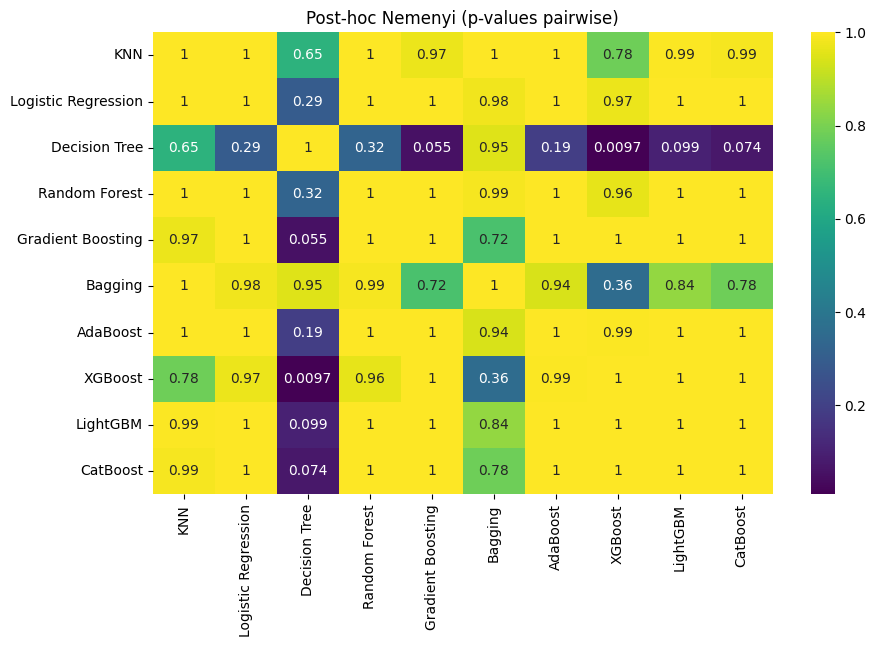

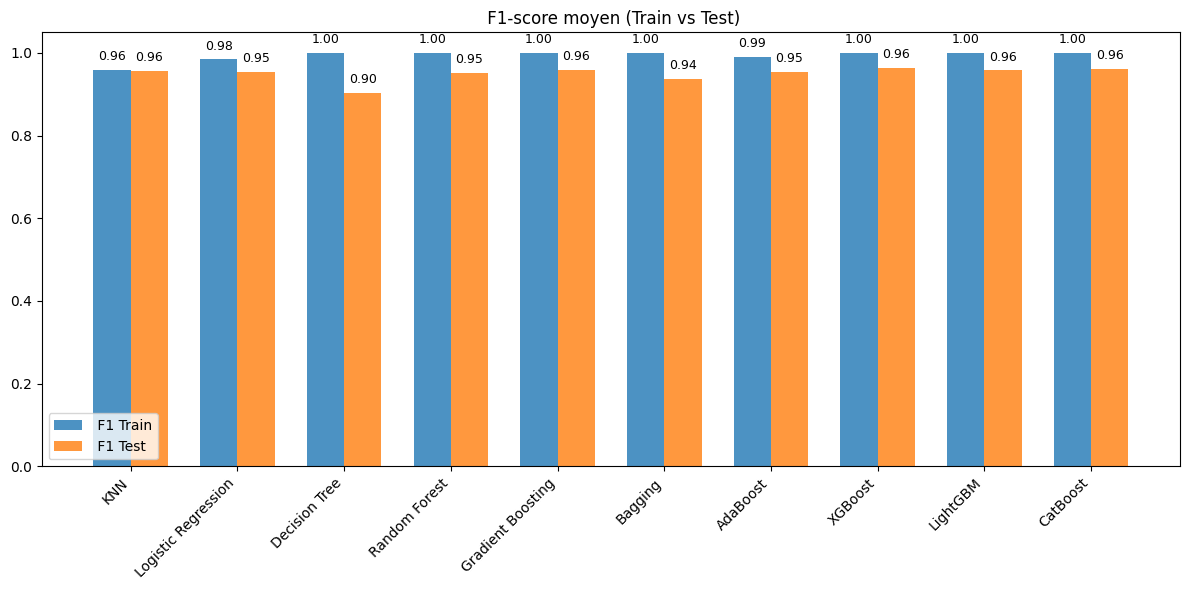

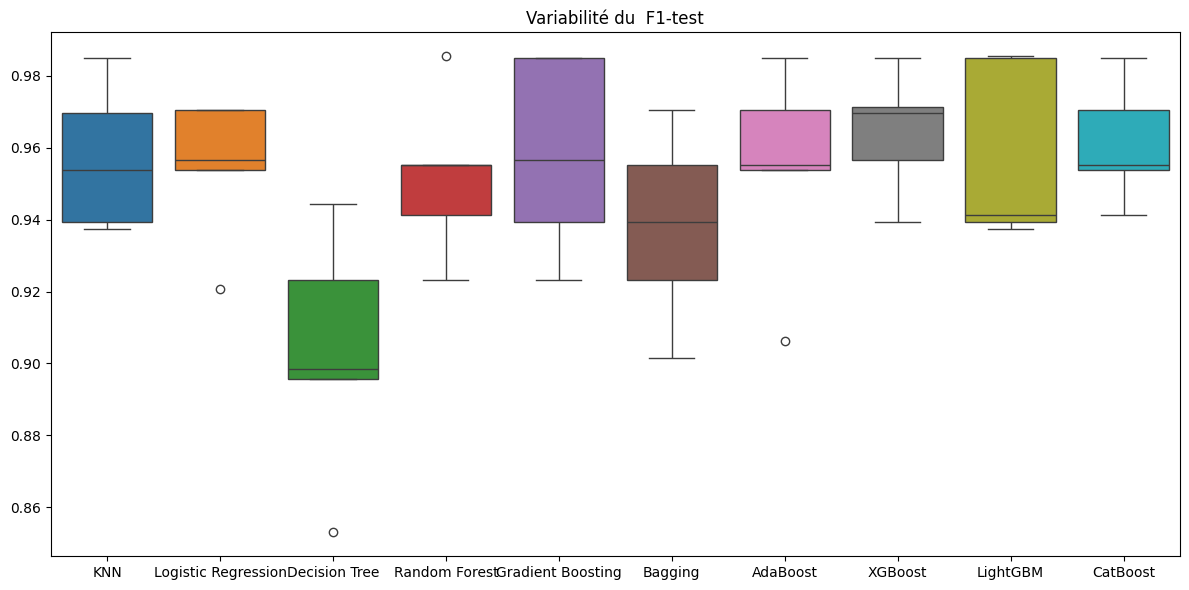

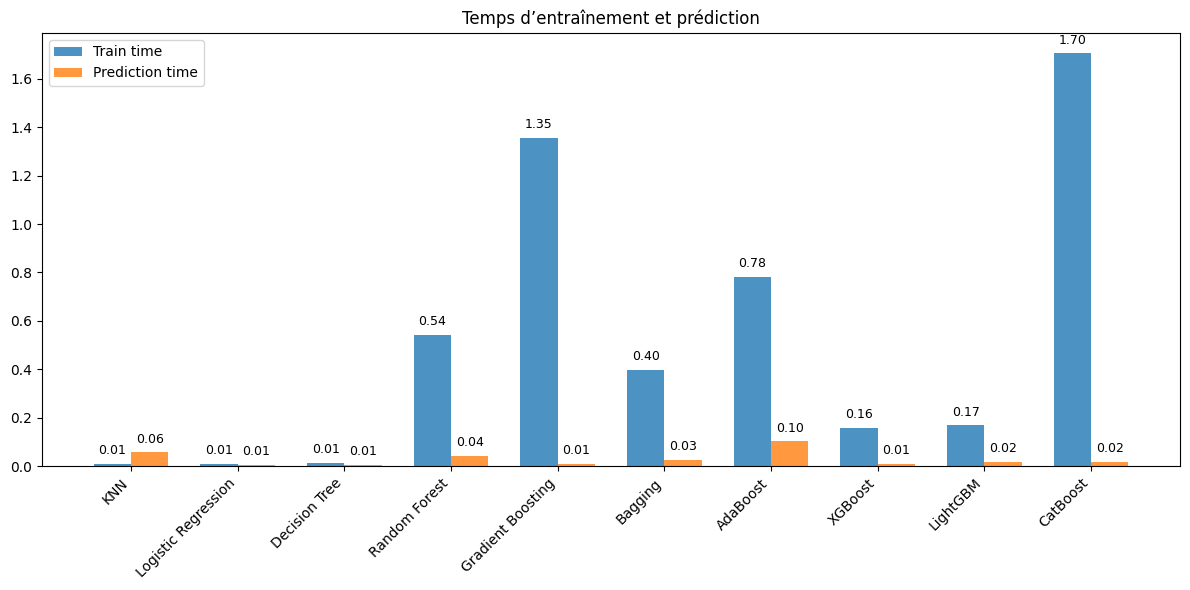

,F1_train_mean,F1_test_mean,F1_test_std,Train_time,Pred_time,Score_global
KNN,0.959684,0.957102,0.018163,0.008532,0.057172,0.954714
Logistic Regression,0.984309,0.954436,0.018270,0.010399,0.005201,0.952557
Decision Tree,1.000000,0.902907,0.030667,0.013186,0.005600,0.899784
Random Forest,1.000000,0.952042,0.020480,0.541697,0.042100,0.949573
Gradient Boosting,1.000000,0.957828,0.024633,1.354054,0.010261,0.955262
Bagging,1.000000,0.937938,0.024175,0.399385,0.026799,0.935253
AdaBoost,0.990340,0.954197,0.026541,0.783405,0.102603,0.950516
XGBoost,1.000000,0.964423,0.015442,0.160001,0.009799,0.962781
LightGBM,1.000000,0.957730,0.022533,0.168614,0.016801,0.955309
CatBoost,1.000000,0.961182,0.015158,1.703895,0.016199,0.959504


In [12]:
modelisation_classification_binaire_F1_visualisee(X_train, y_train, cv_splits=5)

1. Modèles les plus performants (F1-test)

Les meilleurs scores F1-test sont obtenus par :

XGBoost : 0.9644 :  meilleur équilibre précision / rappel. Selon les test de Friedman, il y a pas de différence significative entre XGBoost et les 3 autres modèles suivants. 

KNN : 0.9571

Gradient Boosting : 0.9578

LightGBM : 0.9577

CatBoost : 0.9612

Les modèles XGBoost et CatBoost se détachent nettement, avec une excellente capacité à identifier correctement la classe positive tout en limitant les erreurs.

2. Variabilité des modèles

Les modèles les plus stables (F1-test std faible) sont :

CatBoost : 0.0152

XGBoost : 0.0154

KNN : 0.0182

Logistic Regression : 0.0183

Un écart type bas indique des performances régulières d’un fold à l’autre, ce qui renforce la fiabilité du modèle.

3. Temps d’entraînement et de prédiction

Les plus rapides :

KNN,

Logistic Regression,

Decision Tree

Les plus lents :

CatBoost,

Gradient Boosting,

XGBoost

Même si XGBoost et CatBoost sont plus lourds, leurs performances élevées peuvent justifier leur temps de calcul dans de nombreux cas.

4. Score global (performance + stabilité + vitesse)

Le score global met en avant :

XGBoost : 0.9628 (meilleur compromis) 

CatBoost : 0.9596

KNN : 0.9548

Gradient Boosting : 0.9553

LightGBM : 0.9553




Ce classement montre qu’XGBoost reste le meilleur compromis global, combinant performance élevée, stabilité et un temps de calcul encore raisonnable au vu de sa complexité. CatBoost arrive juste derrière, tandis que KNN et LightGBM offrent d’excellents résultats avec des temps de calcul plus faibles.

## II. Optimisation des modèles

Pour optimiser la performance de nos modèles, nous allons utilisé plusieurs techniques à savoir:
* Le feature_engineering
* La réduction de dimensionnalité 
* Une gestion plus efficaces des outliers
* L'optimisation des hyperparamètres via RandomizedSearchCV

### 1. feature engineering

Nous allons donc créer une fonction qui prend notre dataframe en entré et qui nous le retourne avec de nouvelles variables ajoutées. 

In [14]:
import pandas as pd
import numpy as np

def add_breast_cancer_features(df):
    """
    Ajoute de nouvelles caractéristiques (feature engineering) adaptées à la nomenclature simplifiée :
    1 = mean, 2 = se, 3 = worst.
    
    Exemple de colonnes attendues : area1, area2, area3, compactness1, concavity1, symmetry1, etc.
    
    Paramètres :
        df (pd.DataFrame) : DataFrame contenant les caractéristiques et la variable cible 'Diagnosis' (0/1)
    
    Retour :
        pd.DataFrame : DataFrame complet avec les nouvelles caractéristiques ajoutées
    """
    data = df.copy()

    # --- Vérification de la présence de la variable cible ---
    if 'Diagnosis' not in data.columns:
        raise ValueError("La colonne 'Diagnosis' doit être présente dans le DataFrame.")

    # Séparation X / y
    X = data.drop(columns=['Diagnosis'])
    y = data['Diagnosis']

    # --- Création de nouvelles caractéristiques ---

    # Rapport surface/compacité (densité cellulaire)
    X['Area_to_Compactness'] = X['area1'] / (X['compactness1'] + 1e-6)

    #  Rapport concavité/symétrie (mesure d'irrégularité de forme)
    X['Concavity_Symmetry_Ratio'] = X['concavity1'] / (X['symmetry1'] + 1e-6)

    #Indice global de complexité de forme (surface + périmètre + rayon moyens)
    X['Shape_Complexity'] = (X['area1'] + X['perimeter1'] + X['radius1']) / 3

    # Indice de texture moyen entre état normal et extrême
    X['Texture_Index'] = (X['texture1'] + X['texture3']) / 2

    # Différence entre la plus grande et la moyenne des surfaces (variation intra-échantillon)
    X['Area_Diff'] = X['area3'] - X['area1']

    # Évolution de la compacité entre état normal et extrême
    X['Compactness_Progression'] = X['compactness3'] - X['compactness1']

    #  Transformation logarithmique pour stabiliser les variables très étalées
    X['log_area1'] = np.log1p(X['area1'])
    X['log_area3'] = np.log1p(X['area3'])

    # --- Réintégration de la cible ---
    X['Diagnosis'] = y

    # --- Résumé ---
    new_features = [
        'Area_to_Compactness',
        'Concavity_Symmetry_Ratio',
        'Shape_Complexity',
        'Texture_Index',
        'Area_Diff',
        'Compactness_Progression',
        'log_area1',
        'log_area3'
    ]

    print(f"Nouvelles caractéristiques ajoutées : {', '.join(new_features)}")
    print(f"Le DataFrame final contient {X.shape[1]} colonnes.")

    return X


In [15]:
df_feature_eng=add_breast_cancer_features(train)

Nouvelles caractéristiques ajoutées : Area_to_Compactness, Concavity_Symmetry_Ratio, Shape_Complexity, Texture_Index, Area_Diff, Compactness_Progression, log_area1, log_area3
Le DataFrame final contient 39 colonnes.


In [27]:
df_feature_eng.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3,Area_to_Compactness,Concavity_Symmetry_Ratio,Shape_Complexity,Texture_Index,Area_Diff,Compactness_Progression,log_area1,log_area3,Diagnosis
10,16.02,23.24,102.70,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697,0.3795,1.1870,2.466,40.51,0.004029,0.009269,0.01101,0.007591,0.01460,0.003042,19.19,33.88,123.80,1150.0,0.11810,0.1551,0.1459,0.09975,0.2948,0.08452,11962.633639,0.215902,305.506667,28.560,352.2,0.08841,6.683111,7.048386,1
170,12.32,12.39,78.85,464.1,0.10280,0.06981,0.03987,0.03700,0.1959,0.05955,0.2360,0.6656,1.670,17.43,0.008045,0.011800,0.01683,0.012410,0.01924,0.002248,13.50,15.64,86.97,549.1,0.13850,0.1266,0.1242,0.09391,0.2827,0.06771,6647.949464,0.203521,185.090000,14.015,85.0,0.05679,6.142252,6.310100,0
407,12.85,21.37,82.63,514.5,0.07551,0.08316,0.06126,0.01867,0.1580,0.06114,0.4993,1.7980,2.552,41.24,0.006011,0.044800,0.05175,0.013410,0.02669,0.007731,14.40,27.01,91.63,645.8,0.09402,0.1936,0.1838,0.05601,0.2488,0.08151,6186.794291,0.387719,203.326667,24.190,131.3,0.11044,6.245137,6.472037,0
430,14.90,22.53,102.10,685.0,0.09947,0.22250,0.27330,0.09711,0.2041,0.06898,0.2530,0.8749,3.466,24.19,0.006965,0.062130,0.07926,0.022340,0.01499,0.005784,16.35,27.57,125.40,832.7,0.14190,0.7090,0.9019,0.24750,0.2866,0.11550,3078.637849,1.339043,267.333333,25.050,147.7,0.48650,6.530878,6.725874,1
27,18.61,20.25,122.10,1094.0,0.09440,0.10660,0.14900,0.07731,0.1697,0.05699,0.8529,1.8490,5.632,93.54,0.010750,0.027220,0.05081,0.019110,0.02293,0.004217,21.31,27.26,139.90,1403.0,0.13380,0.2117,0.3446,0.14900,0.2341,0.07421,10262.567893,0.878015,411.570000,23.755,309.0,0.10510,6.998510,7.247081,1



  Début de la validation croisée (CV=5)  

--- Modèle : KNN ---
 F1-train = 0.961 |  F1-test = 0.963
Temps entraînement = 0.0086s | Temps prédiction = 0.0887s

--- Modèle : Logistic Regression ---
 F1-train = 0.987 |  F1-test = 0.961
Temps entraînement = 0.0150s | Temps prédiction = 0.0069s

--- Modèle : Decision Tree ---
 F1-train = 1.000 |  F1-test = 0.919
Temps entraînement = 0.0241s | Temps prédiction = 0.0098s

--- Modèle : Random Forest ---
 F1-train = 1.000 |  F1-test = 0.952
Temps entraînement = 0.5666s | Temps prédiction = 0.0406s

--- Modèle : Gradient Boosting ---
 F1-train = 1.000 |  F1-test = 0.976
Temps entraînement = 1.5660s | Temps prédiction = 0.0090s

--- Modèle : Bagging ---
 F1-train = 1.000 |  F1-test = 0.961
Temps entraînement = 0.4511s | Temps prédiction = 0.0307s

--- Modèle : AdaBoost ---
 F1-train = 0.992 |  F1-test = 0.960
Temps entraînement = 0.8951s | Temps prédiction = 0.1063s

--- Modèle : XGBoost ---


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:43:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:43:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:43:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:19

 F1-train = 1.000 |  F1-test = 0.967
Temps entraînement = 1.2550s | Temps prédiction = 0.0156s

--- Modèle : LightGBM ---
[LightGBM] [Info] Number of positive: 136, number of negative: 228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4618
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 136, number of negative: 228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4623
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 F1-train = 1.000 |  F1-test = 0.963
Temps entraînement = 2.1226s | Temps prédiction = 0.0184s


  Fin de la validation croisée  

  Meilleur modèle identifié  
F1_train_mean    1.000000
F1_test_mean     0.976029
F1_test_std      0.011987
Train_time       1.566000
Pred_time        0.009001
Score_global     0.974740
Name: Gradient Boosting, dtype: float64



===== Test de Friedman =====
Statistique χ² = 16.3443
p-value        = 0.0600
→ Aucune preuve statistique que les modèles diffèrent (p ≥ 0.05).


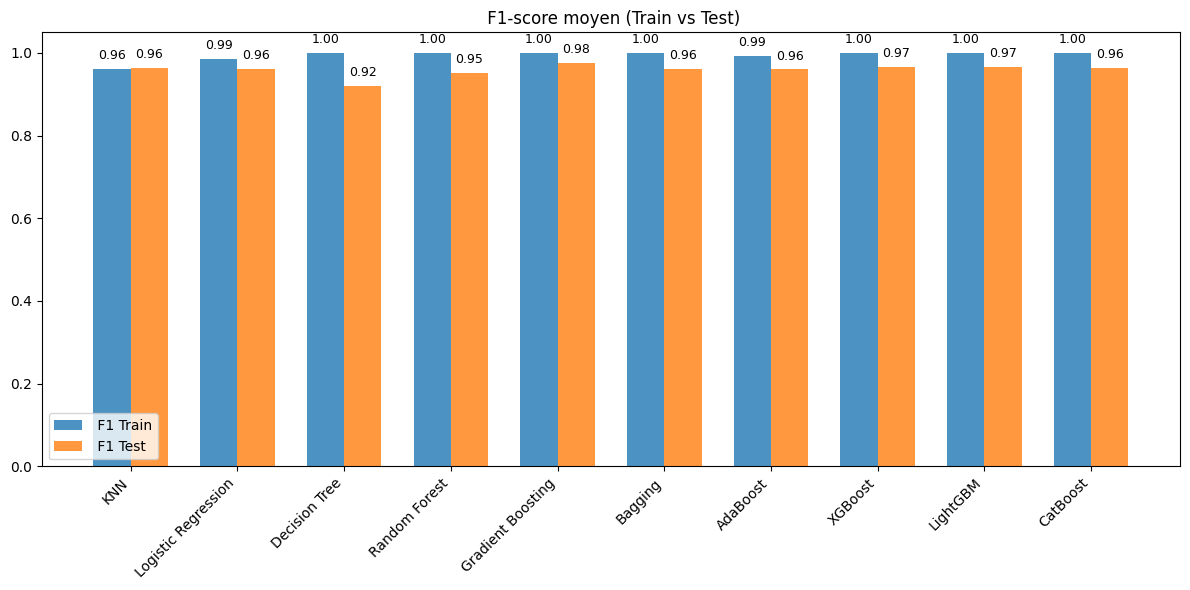

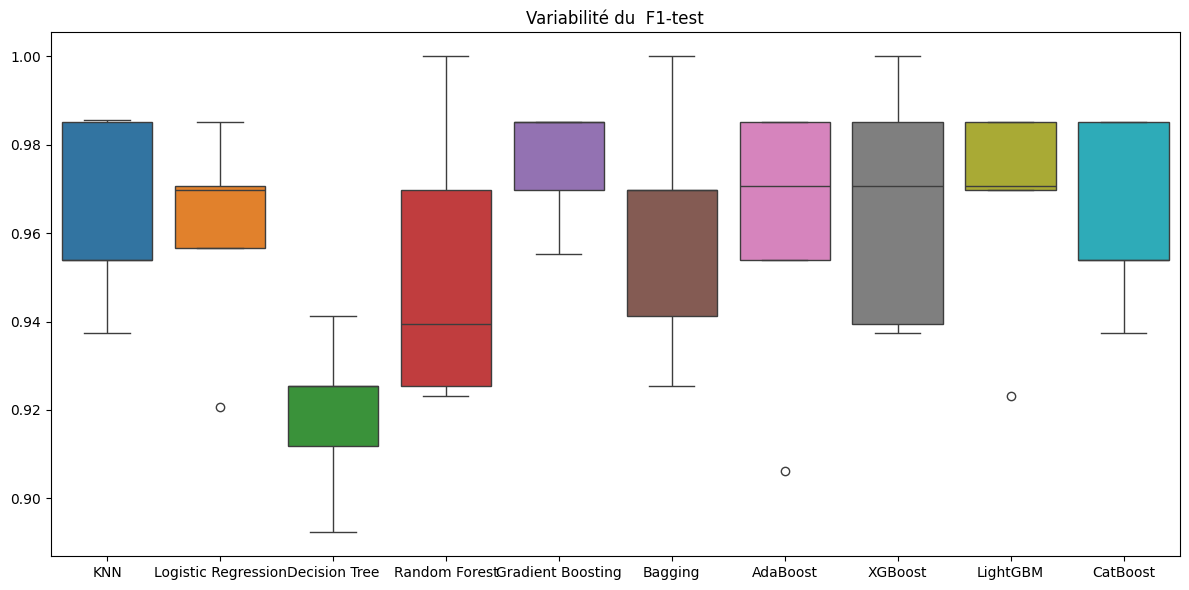

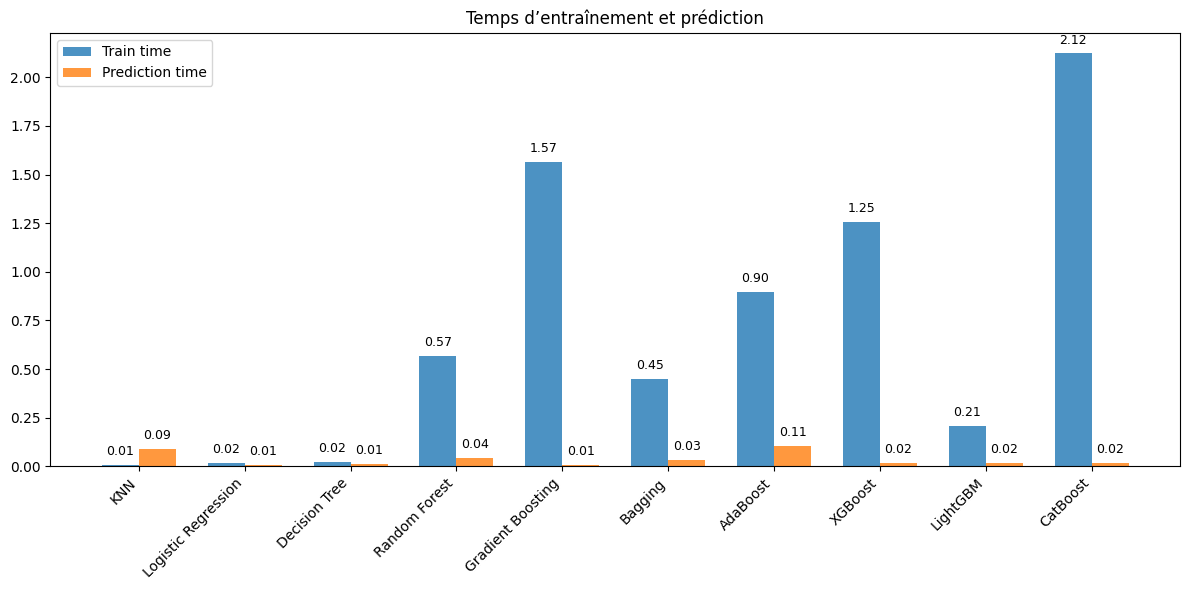

,F1_train_mean,F1_test_mean,F1_test_std,Train_time,Pred_time,Score_global
KNN,0.961181,0.963155,0.019035,0.008588,0.088713,0.960364
Logistic Regression,0.986578,0.960503,0.021888,0.015021,0.006950,0.958245
Decision Tree,1.000000,0.919199,0.016356,0.024085,0.009800,0.917465
Random Forest,1.000000,0.951508,0.029395,0.566604,0.040628,0.948162
Gradient Boosting,1.000000,0.976029,0.011987,1.566000,0.009001,0.974740
Bagging,1.000000,0.961189,0.025824,0.451078,0.030711,0.958299
AdaBoost,0.991844,0.960167,0.029313,0.895078,0.106288,0.956173
XGBoost,1.000000,0.966511,0.024737,1.254980,0.015621,0.963881
LightGBM,1.000000,0.966702,0.022814,0.206873,0.017239,0.964249
CatBoost,1.000000,0.963068,0.018934,2.122649,0.018401,0.960991


In [17]:
X_eng = df_feature_eng.drop(columns=['Diagnosis'])
y_eng = df_feature_eng['Diagnosis']
modelisation_classification_binaire_F1_visualisee(X_eng, y_eng, cv_splits=5,test_friedman=True)

L’ajout des nouvelles caractéristiques issues de la fonction add_breast_cancer_features a permis d’augmenter la qualité descriptive du dataset en introduisant des indicateurs de forme, de complexité et d’évolution des anomalies cellulaires. Ces variables supplémentaires semblent avoir amélioré la capacité des modèles à distinguer correctement les tumeurs malignes, ce qui se reflète directement dans les valeurs du F1-score, métrique centrée sur le rappel.

Les performances observées montrent :

Gradient Boosting devient le modèle le plus performant avec un F1_test ≈ 0.976.
Sa forte capacité à exploiter les interactions complexes entre les nouvelles variables lui permet d’atteindre une excellente précision, renforçant sa position en tête malgré un temps d’entraînement élevé.

LightGBM et XGBoost restent très performants (F1_test ≈ 0.967).
Ils profitent particulièrement des nouvelles interactions implicites entre les variables. Leur combinaison de puissance prédictive, de stabilité et de rapidité relative confirme leur très bonne capacité de généralisation.

KNN, CatBoost et Bagging conservent d’excellents résultats, avec des F1_test compris entre 0.96 et 0.963.
Ils bénéficient nettement des nouvelles features, notamment KNN qui progresse et devient plus compétitif, même s'il demeure légèrement derrière les modèles de boosting.

Logistic Regression reste très solide avec un F1_test ≈ 0.960.
Sa stabilité et sa rapidité montrent que les nouvelles features améliorent la séparabilité linéaire du problème, ce qui renforce son efficacité globale.

Random Forest, AdaBoost et plus encore Decision Tree obtiennent des performances correctes mais inférieures aux modèles précédents.
Bien qu’ils profitent eux aussi des nouvelles variables, ils captent moins bien la structure complexe introduite, ce qui explique des F1_test plus faibles, notamment pour Decision Tree qui reste le moins compétitif.

### 2. Gestion plus strict des données abérantes

Nous avons essayer de revoir un un peu la gestion des valeurs abérantes en utilisant la méthode IQR (Interquartile Range)

Pour ça nous avons écris une fonction que nous allons utilisé dans la fonction de prétraitrement et entrainement 

In [29]:
import pandas as pd
import numpy as np

def remove_outliers_zscore(df, columns, threshold=3):
    """
    Supprime les valeurs extrêmes (outliers) en utilisant la méthode du Z-score.
    
    Paramètres :
        df (pd.DataFrame) : DataFrame d'entrée
        columns (list) : liste des colonnes à traiter
        threshold (float) : valeur limite du Z-score (par défaut 3)
        
    Retour :
        pd.DataFrame : DataFrame nettoyé des outliers
    """
    df_clean = df.copy()

    for col in columns:
        mean = df_clean[col].mean()
        std = df_clean[col].std()
        
        # Calcul du Z-score
        z_scores = (df_clean[col] - mean) / std
        
        # Filtrage des valeurs
        df_clean = df_clean[abs(z_scores) <= threshold]
    
    print(f"Nettoyage terminé : {len(df) - len(df_clean)} valeurs extrêmes supprimées au total.")
    return df_clean


In [30]:
cols = ['area1', 'area2', 'area3']

df_clean = remove_outliers_zscore(train, cols, threshold=3)

Nettoyage terminé : 22 valeurs extrêmes supprimées au total.



===== Début de la validation croisée (CV=5) =====

--- Modèle : KNN ---
 F1-train = 0.948 |  F1-test = 0.935
Temps entraînement = 0.0086s | Temps prédiction = 0.0612s

--- Modèle : Logistic Regression ---
 F1-train = 0.983 |  F1-test = 0.955
Temps entraînement = 0.0150s | Temps prédiction = 0.0073s

--- Modèle : Decision Tree ---
 F1-train = 1.000 |  F1-test = 0.893
Temps entraînement = 0.0149s | Temps prédiction = 0.0037s

--- Modèle : Random Forest ---
 F1-train = 1.000 |  F1-test = 0.921
Temps entraînement = 0.4809s | Temps prédiction = 0.0388s

--- Modèle : Gradient Boosting ---
 F1-train = 1.000 |  F1-test = 0.937
Temps entraînement = 1.1526s | Temps prédiction = 0.0098s

--- Modèle : Bagging ---
 F1-train = 0.999 |  F1-test = 0.928
Temps entraînement = 0.3553s | Temps prédiction = 0.0258s

--- Modèle : AdaBoost ---
 F1-train = 0.987 |  F1-test = 0.941
Temps entraînement = 0.7099s | Temps prédiction = 0.0968s

--- Modèle : XGBoost ---


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:31:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:31:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:31:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:19

 F1-train = 1.000 |  F1-test = 0.924
Temps entraînement = 0.1525s | Temps prédiction = 0.0085s

--- Modèle : LightGBM ---
[LightGBM] [Info] Number of positive: 118, number of negative: 228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3470
[LightGBM] [Info] Number of data points in the train set: 346, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341040 -> initscore=-0.658661
[LightGBM] [Info] Start training from score -0.658661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 F1-train = 1.000 |  F1-test = 0.944
Temps entraînement = 0.1429s | Temps prédiction = 0.0186s

--- Modèle : CatBoost ---
 F1-train = 1.000 |  F1-test = 0.939
Temps entraînement = 1.3716s | Temps prédiction = 0.0093s


===== Fin de la validation croisée =====

===== Meilleur modèle identifié =====
F1_train_mean    0.982803
F1_test_mean     0.955342
F1_test_std      0.020730
Train_time       0.015016
Pred_time        0.007278
Score_global     0.953196
Name: Logistic Regression, dtype: float64




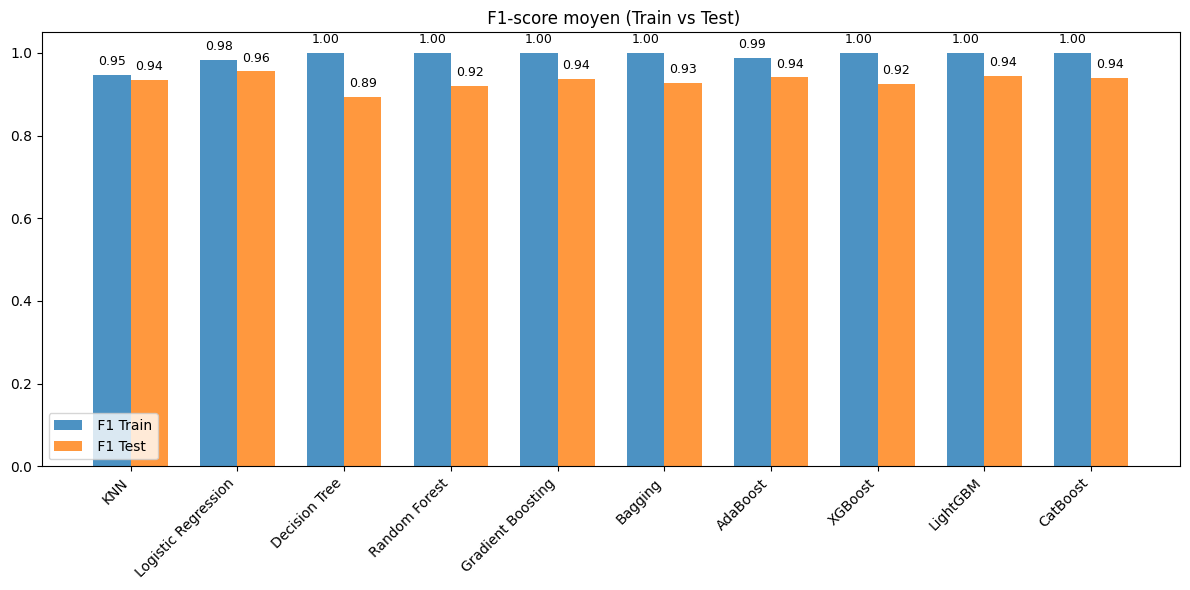

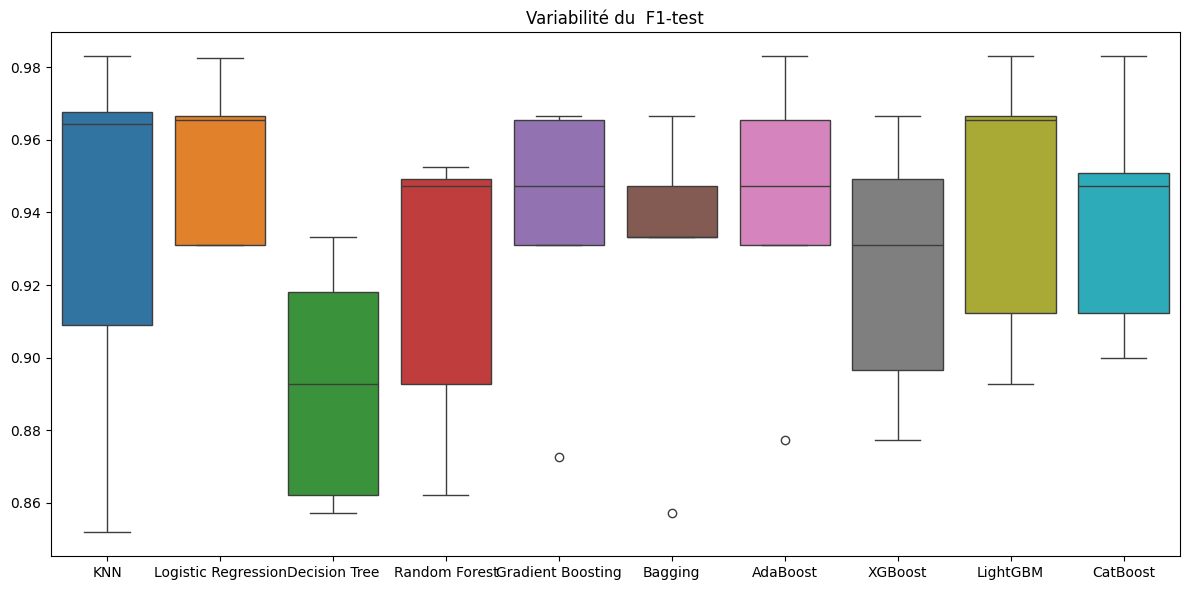

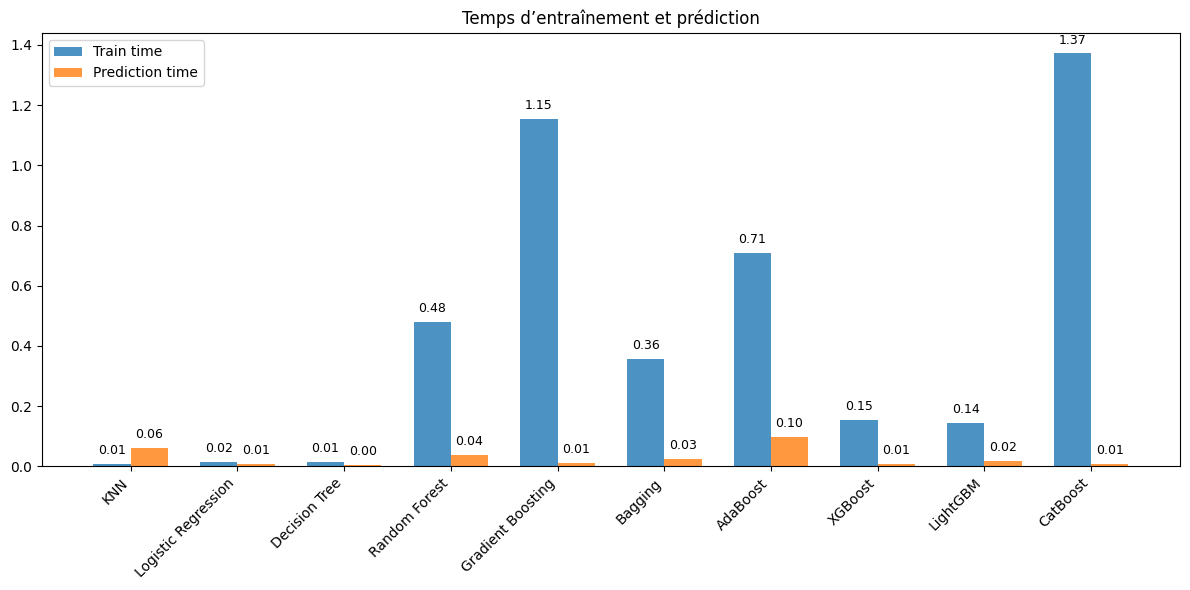

,F1_train_mean,F1_test_mean,F1_test_std,Train_time,Pred_time,Score_global
KNN,0.947548,0.935204,0.048628,0.008598,0.061164,0.929730
Logistic Regression,0.982803,0.955342,0.020730,0.015016,0.007278,0.953196
Decision Tree,1.000000,0.892687,0.029985,0.014936,0.003655,0.889652
Random Forest,1.000000,0.920766,0.036708,0.480923,0.038824,0.916707
Gradient Boosting,1.000000,0.936663,0.034545,1.152646,0.009812,0.933110
Bagging,0.999156,0.927569,0.037274,0.355289,0.025782,0.923584
AdaBoost,0.987124,0.940833,0.036278,0.709929,0.096841,0.936237
XGBoost,1.000000,0.924120,0.033005,0.152451,0.008477,0.920734
LightGBM,1.000000,0.944075,0.034995,0.142897,0.018572,0.940389
CatBoost,1.000000,0.938704,0.029613,1.371570,0.009283,0.935650


In [31]:
X_eng = df_clean.drop(columns=['Diagnosis'])
y_eng = df_clean['Diagnosis']
modelisation_classification_binaire_F1_visualisee(X_eng, y_eng, cv_splits=5)

La suppression des valeurs extrêmes grâce à la fonction remove_outliers_zscore a contribué à rendre le dataset plus homogène en éliminant les observations atypiques susceptibles de perturber les frontières de décision. En réduisant le bruit statistique, les modèles deviennent plus cohérents dans leur apprentissage, ce qui se reflète dans une meilleure stabilité des F1-scores, particulièrement pertinente pour la détection des tumeurs malignes.

Les performances observées montrent :

Logistic Regression devient le modèle le plus performant avec un F1_test ≈ 0.955, combinant bonne stabilité et excellente rapidité, ce qui confirme son efficacité sur un dataset nettoyé.

AdaBoost, LightGBM et CatBoost obtiennent également de bons résultats (F1_test ≈ 0.94), avec une stabilité correcte, même si CatBoost reste pénalisé par un temps d’entraînement élevé.

KNN, Gradient Boosting et Bagging atteignent des scores intermédiaires (F1_test ≈ 0.93–0.94) mais souffrent d’une variabilité plus marquée, en particulier KNN.

XGBoost et Random Forest sont un peu moins performants (F1_test ≈ 0.92), avec une variance non négligeable et des temps de calcul parfois conséquents.

Decision Tree reste clairement le moins performant, affichant un F1_test ≈ 0.89 et une stabilité limitée, ce qui reflète sa difficulté à modéliser les relations plus fines du dataset nettoyé.

### 3. Réduction de dimensionnalité

Nous allons faire la réduction des variables de plusieurs manière

ensuite evaluer la performance de nos modèles. 


 Application de la méthode : RFE
→ Après RFE : 10 variables conservées.


  Début de la validation croisée (CV=5)  

--- Modèle : KNN ---
 F1-train = 0.934 |  F1-test = 0.929
Temps entraînement = 0.0078s | Temps prédiction = 0.0500s

--- Modèle : Logistic Regression ---
 F1-train = 0.950 |  F1-test = 0.942
Temps entraînement = 0.0113s | Temps prédiction = 0.0073s

--- Modèle : Decision Tree ---
 F1-train = 1.000 |  F1-test = 0.893
Temps entraînement = 0.0108s | Temps prédiction = 0.0068s

--- Modèle : Random Forest ---
 F1-train = 1.000 |  F1-test = 0.937
Temps entraînement = 0.5271s | Temps prédiction = 0.0517s

--- Modèle : Gradient Boosting ---
 F1-train = 1.000 |  F1-test = 0.925
Temps entraînement = 0.5690s | Temps prédiction = 0.0082s

--- Modèle : Bagging ---
 F1-train = 0.999 |  F1-test = 0.923
Temps entraînement = 0.1856s | Temps prédiction = 0.0262s

--- Modèle : AdaBoost ---
 F1-train = 0.960 |  F1-test = 0.925
Temps entraînement = 0.5213s | Temps prédiction = 0.1134s

--- 

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:46:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:46:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:46:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:19

 F1-train = 1.000 |  F1-test = 0.938
Temps entraînement = 0.1264s | Temps prédiction = 0.0096s

--- Modèle : LightGBM ---
[LightGBM] [Info] Number of positive: 136, number of negative: 228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1216
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 136, number of negative: 228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1214
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from sco

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 F1-train = 1.000 |  F1-test = 0.934
Temps entraînement = 0.9025s | Temps prédiction = 0.0100s


  Fin de la validation croisée  

  Meilleur modèle identifié  
F1_train_mean    0.949576
F1_test_mean     0.942159
F1_test_std      0.024877
Train_time       0.011291
Pred_time        0.007297
Score_global     0.939598
Name: Logistic Regression, dtype: float64



===== Test de Friedman =====
Statistique χ² = 8.9430
p-value        = 0.4425
→ Aucune preuve statistique que les modèles diffèrent (p ≥ 0.05).


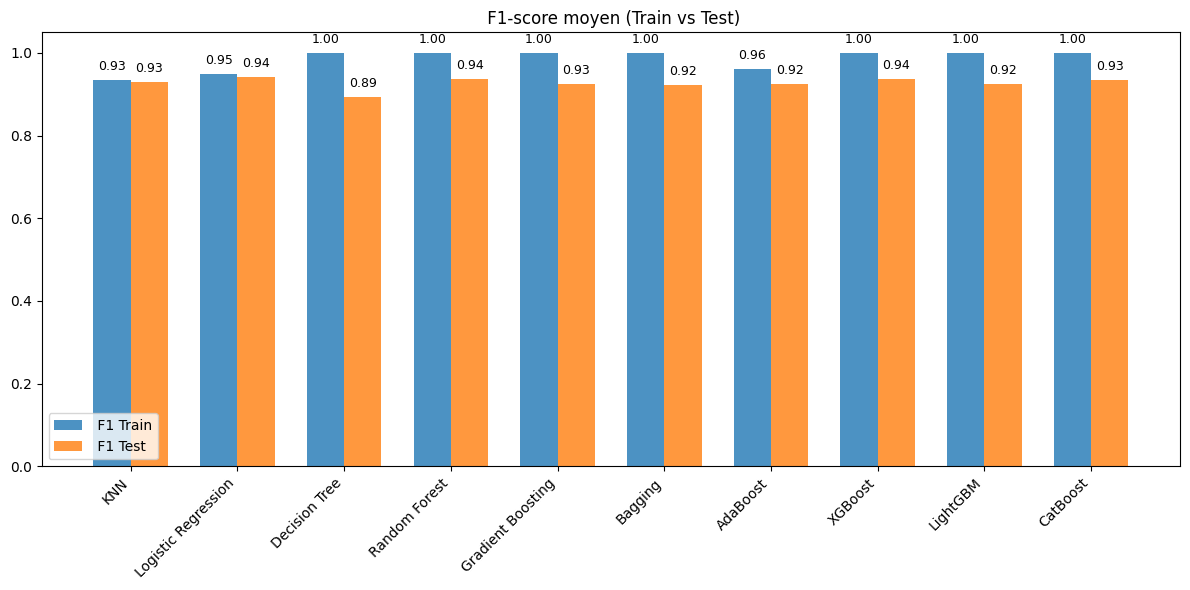

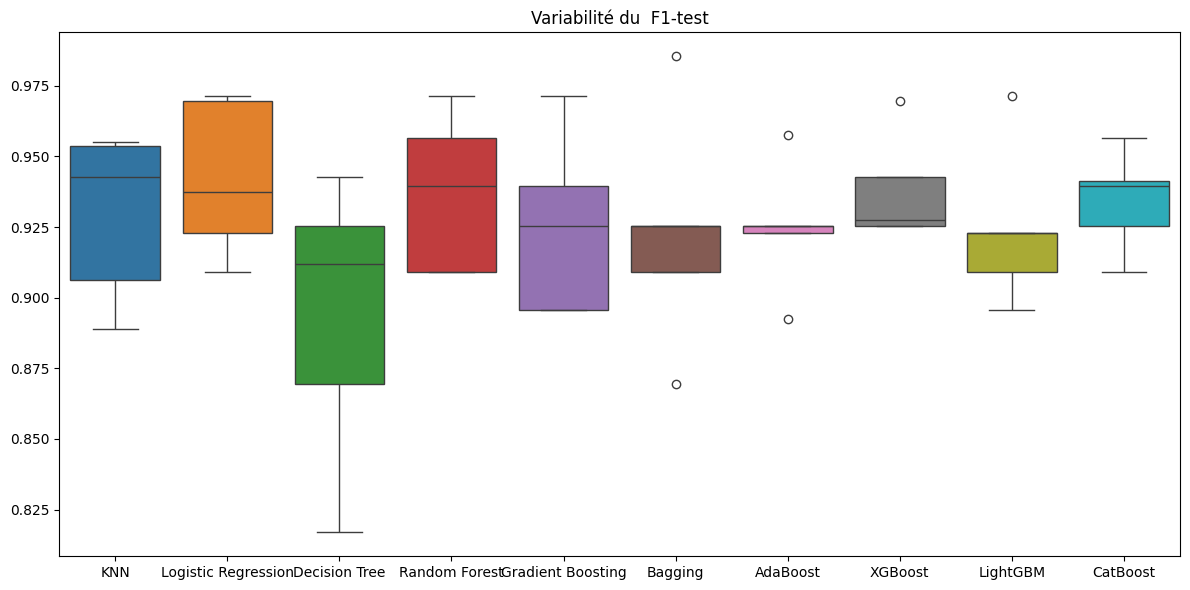

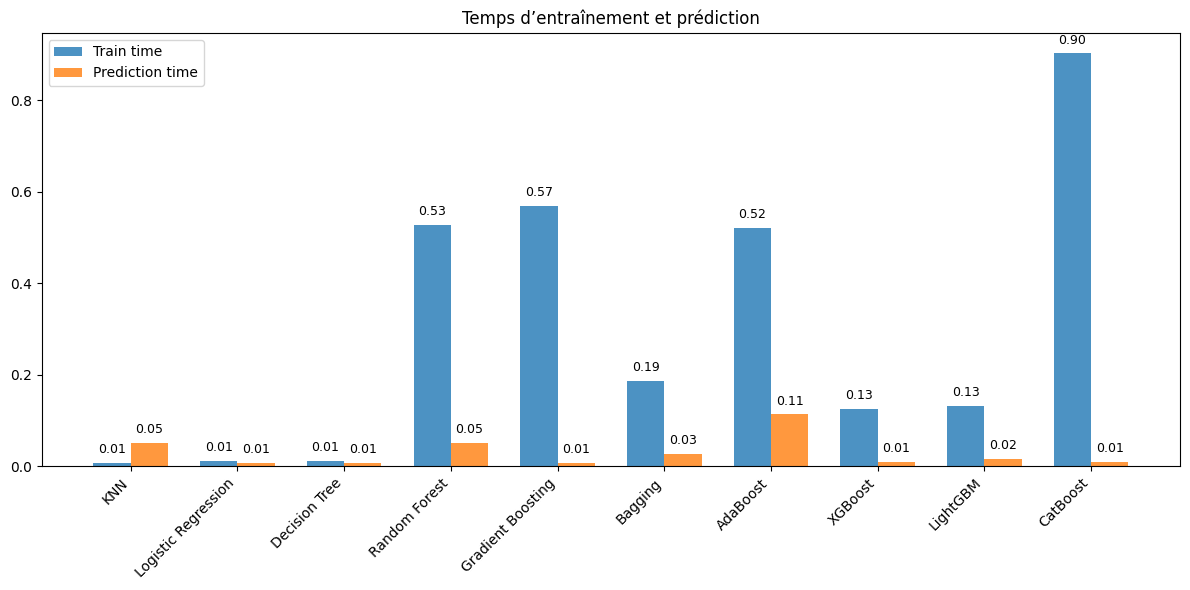

,F1_train_mean,F1_test_mean,F1_test_std,Train_time,Pred_time,Score_global
KNN,0.933891,0.929413,0.026917,0.007835,0.050034,0.926221
Logistic Regression,0.949576,0.942159,0.024877,0.011291,0.007297,0.939598
Decision Tree,1.000000,0.893292,0.045223,0.010799,0.006796,0.888702
Random Forest,1.000000,0.937105,0.025020,0.527115,0.051658,0.934087
Gradient Boosting,1.000000,0.925448,0.028635,0.569015,0.008199,0.922503
Bagging,0.999262,0.922982,0.037329,0.185600,0.026211,0.918987
AdaBoost,0.960311,0.924775,0.020712,0.521252,0.113364,0.921571
XGBoost,1.000000,0.938167,0.017068,0.126400,0.009599,0.936365
LightGBM,1.000000,0.924439,0.025626,0.131744,0.016601,0.921711
CatBoost,1.000000,0.934311,0.016014,0.902480,0.009997,0.932610


In [19]:
X_proc, y = advanced_feature_preprocessing_breast_cancer(
    train,
    n_features=10,
    n_components=5,
    methods=['RFE']
)
modelisation_classification_binaire_F1_visualisee(X_proc, y, cv_splits=5)

L’utilisation de RFE a simplifié le dataset en ne conservant que les variables les plus pertinentes, ce qui améliore la stabilité des modèles. Les résultats montrent :

La régression logistique devient la meilleure méthode (F1_test ≈ 0.94) grâce à un dataset plus linéaire et plus propre.
Random Forest et XGBoost restent performants (≈ 0.93–0.94) et relativement stables.
AdaBoost, LightGBM, Gradient Boosting et Bagging obtiennent des scores corrects (≈ 0.92–0.93) mais sont légèrement pénalisés par la perte d’interactions.
KNN et l’arbre de décision restent les moins efficaces, avec des performances plus faibles et une variabilité plus élevée.

En résumé, RFE favorise surtout les modèles linéaires et réduit l’impact des modèles complexes.

PCA


 Application de la méthode : PCA
 PCA : 84.94% de variance expliquée
→ Après PCA : 5 variables conservées.


  Début de la validation croisée (CV=5)  

--- Modèle : KNN ---
 F1-train = 0.952 |  F1-test = 0.925
Temps entraînement = 0.0090s | Temps prédiction = 0.0523s

--- Modèle : Logistic Regression ---
 F1-train = 0.967 |  F1-test = 0.961
Temps entraînement = 0.0086s | Temps prédiction = 0.0056s

--- Modèle : Decision Tree ---
 F1-train = 1.000 |  F1-test = 0.890
Temps entraînement = 0.0130s | Temps prédiction = 0.0083s

--- Modèle : Random Forest ---
 F1-train = 1.000 |  F1-test = 0.943
Temps entraînement = 0.4138s | Temps prédiction = 0.0477s

--- Modèle : Gradient Boosting ---
 F1-train = 1.000 |  F1-test = 0.930
Temps entraînement = 0.4276s | Temps prédiction = 0.0078s

--- Modèle : Bagging ---
 F1-train = 1.000 |  F1-test = 0.924
Temps entraînement = 0.1517s | Temps prédiction = 0.0250s

--- Modèle : AdaBoost ---
 F1-train = 0.969 |  F1-test = 0.923
Temps entraînement = 0.4596s

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:46:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:46:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:46:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:19

 F1-train = 1.000 |  F1-test = 0.961
Temps entraînement = 0.1056s | Temps prédiction = 0.0100s

--- Modèle : LightGBM ---
[LightGBM] [Info] Number of positive: 136, number of negative: 228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 136, number of negative: 228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 616
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 F1-train = 1.000 |  F1-test = 0.949
Temps entraînement = 0.8352s | Temps prédiction = 0.0112s


  Fin de la validation croisée  

  Meilleur modèle identifié  
F1_train_mean    1.000000
F1_test_mean     0.960991
F1_test_std      0.012604
Train_time       0.105600
Pred_time        0.010001
Score_global     0.959630
Name: XGBoost, dtype: float64



===== Test de Friedman =====
Statistique χ² = 27.0677
p-value        = 0.0014
→ Les différences entre les modèles sont STATISTIQUEMENT SIGNIFICATIVES (p < 0.05).

Les performances diffèrent → Test post-hoc de Nemenyi en cours...

===== Test post-hoc de Nemenyi =====
                          KNN  Logistic Regression  Decision Tree  \
KNN                  1.000000             0.425242       0.992761   
Logistic Regression  0.425242             1.000000       0.039833   
Decision Tree        0.992761             0.039833       1.000000   
Random Forest        0.839286             0.999807       0.212132   
Gradient Boosting    0.999807         

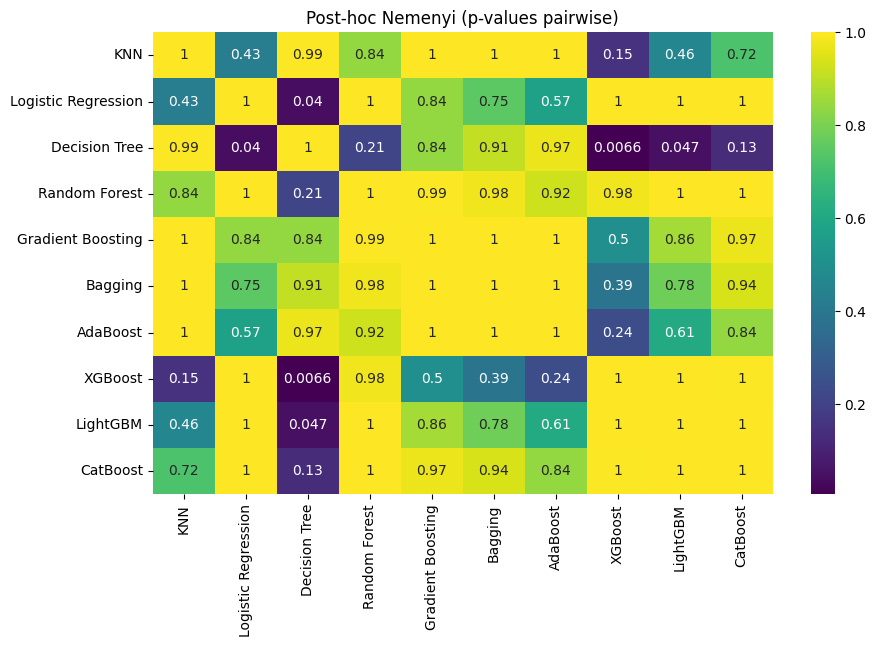

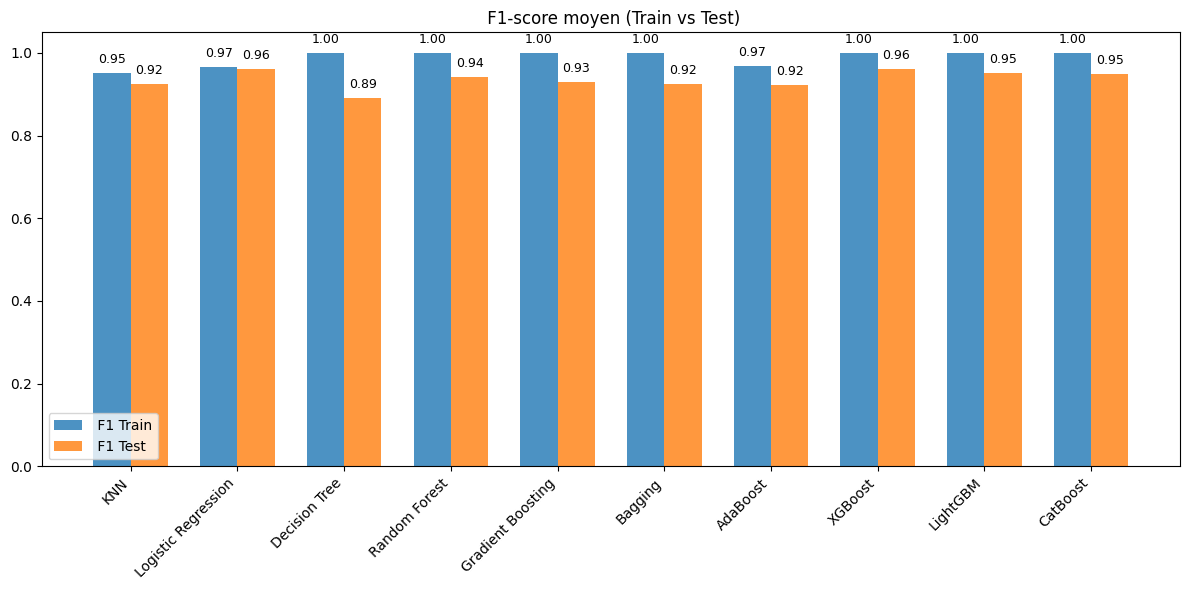

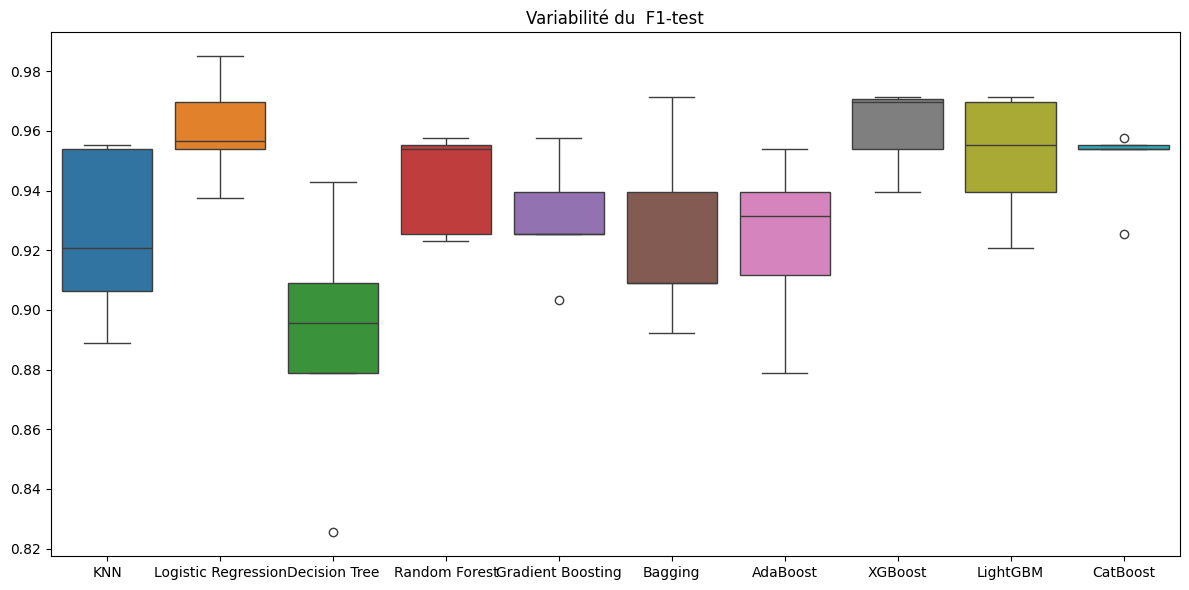

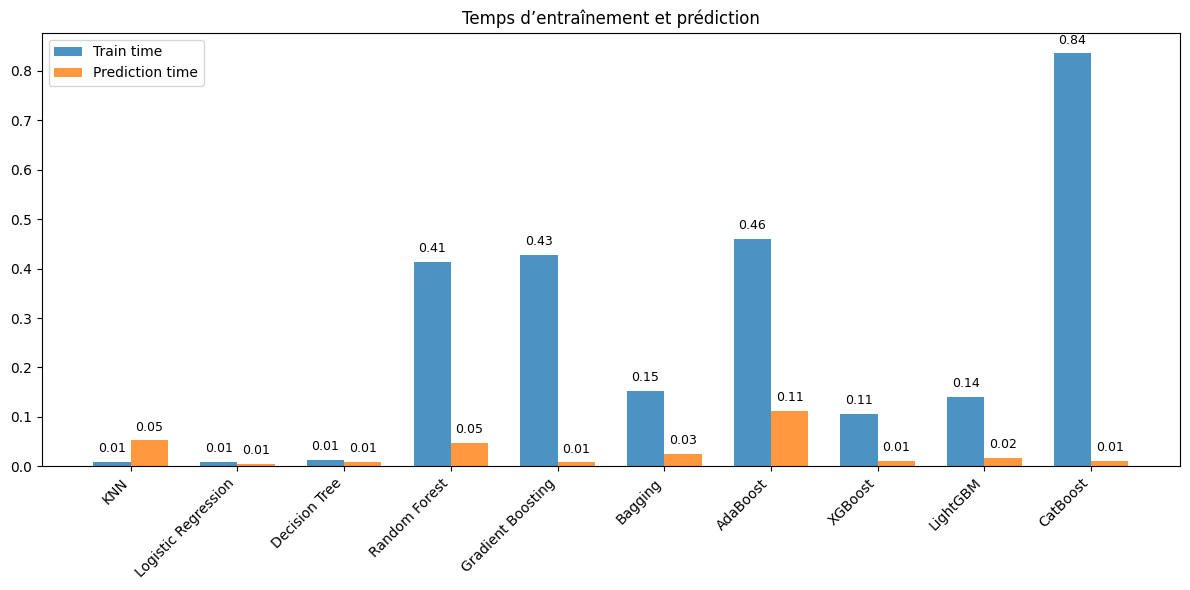

,F1_train_mean,F1_test_mean,F1_test_std,Train_time,Pred_time,Score_global
KNN,0.951786,0.924969,0.026154,0.008997,0.052279,0.921831
Logistic Regression,0.966848,0.960528,0.015985,0.008599,0.005600,0.958873
Decision Tree,1.000000,0.890331,0.038698,0.012998,0.008275,0.886379
Random Forest,1.000000,0.943053,0.015441,0.413812,0.047661,0.941033
Gradient Boosting,1.000000,0.930222,0.017986,0.427618,0.007839,0.928345
Bagging,1.000000,0.924262,0.028054,0.151738,0.025000,0.921207
AdaBoost,0.968937,0.923060,0.025975,0.459576,0.111084,0.919352
XGBoost,1.000000,0.960991,0.012604,0.105600,0.010001,0.959630
LightGBM,1.000000,0.951276,0.019189,0.140718,0.016601,0.949191
CatBoost,1.000000,0.949207,0.012002,0.835164,0.011201,0.947895


In [20]:
X_proc, y = advanced_feature_preprocessing_breast_cancer(
    train,
    n_features=10,
    n_components=5,
    methods=['PCA']
)
modelisation_classification_binaire_F1_visualisee(X_proc, y, cv_splits=5)

L’utilisation de la PCA a réduit la dimension du dataset tout en conservant l’essentiel de l’information, ce qui favorise les modèles sensibles aux relations globales.

XGBoost et la régression logistique deviennent les meilleurs modèles (F1_test ≈ 0.96), montrant que les composantes principales captent efficacement les structures discriminantes. Et le test de friedman montre qu'il n'y a pas de différence significative entre eux.

Random Forest, LightGBM et CatBoost restent solides (F1_test ≈ 0.94–0.95) avec une bonne stabilité.

KNN, Bagging, AdaBoost et Gradient Boosting obtiennent des performances intermédiaires (≈ 0.92–0.93), légèrement pénalisés par la nature linéaire de la PCA.

Decision Tree reste le moins performant, ayant du mal à exploiter des composantes globales moins locales.

ANOVA


 Application de la méthode : ANOVA
→ Après ANOVA : 10 variables conservées.


  Début de la validation croisée (CV=5)  

--- Modèle : KNN ---
 F1-train = 0.937 |  F1-test = 0.917
Temps entraînement = 0.0096s | Temps prédiction = 0.0429s

--- Modèle : Logistic Regression ---
 F1-train = 0.936 |  F1-test = 0.935
Temps entraînement = 0.0114s | Temps prédiction = 0.0056s

--- Modèle : Decision Tree ---
 F1-train = 1.000 |  F1-test = 0.899
Temps entraînement = 0.0094s | Temps prédiction = 0.0060s

--- Modèle : Random Forest ---
 F1-train = 1.000 |  F1-test = 0.935
Temps entraînement = 0.4420s | Temps prédiction = 0.0456s

--- Modèle : Gradient Boosting ---
 F1-train = 1.000 |  F1-test = 0.928
Temps entraînement = 0.6077s | Temps prédiction = 0.0072s

--- Modèle : Bagging ---
 F1-train = 0.999 |  F1-test = 0.912
Temps entraînement = 0.1874s | Temps prédiction = 0.0252s

--- Modèle : AdaBoost ---
 F1-train = 0.947 |  F1-test = 0.937
Temps entraînement = 0.5338s | Temps prédiction = 0.0930s



c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:48:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:48:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:48:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:19

 F1-train = 0.999 |  F1-test = 0.937
Temps entraînement = 0.6144s | Temps prédiction = 0.0136s

--- Modèle : LightGBM ---
[LightGBM] [Info] Number of positive: 136, number of negative: 228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 136, number of negative: 228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 F1-train = 1.000 |  F1-test = 0.931
Temps entraînement = 0.1359s | Temps prédiction = 0.0157s

--- Modèle : CatBoost ---
 F1-train = 1.000 |  F1-test = 0.928
Temps entraînement = 0.8113s | Temps prédiction = 0.0094s


  Fin de la validation croisée  

  Meilleur modèle identifié  
F1_train_mean    0.999262
F1_test_mean     0.937076
F1_test_std      0.036038
Train_time       0.614447
Pred_time        0.013601
Score_global     0.933336
Name: XGBoost, dtype: float64



===== Test de Friedman =====
Statistique χ² = 16.0064
p-value        = 0.0667
→ Aucune preuve statistique que les modèles diffèrent (p ≥ 0.05).


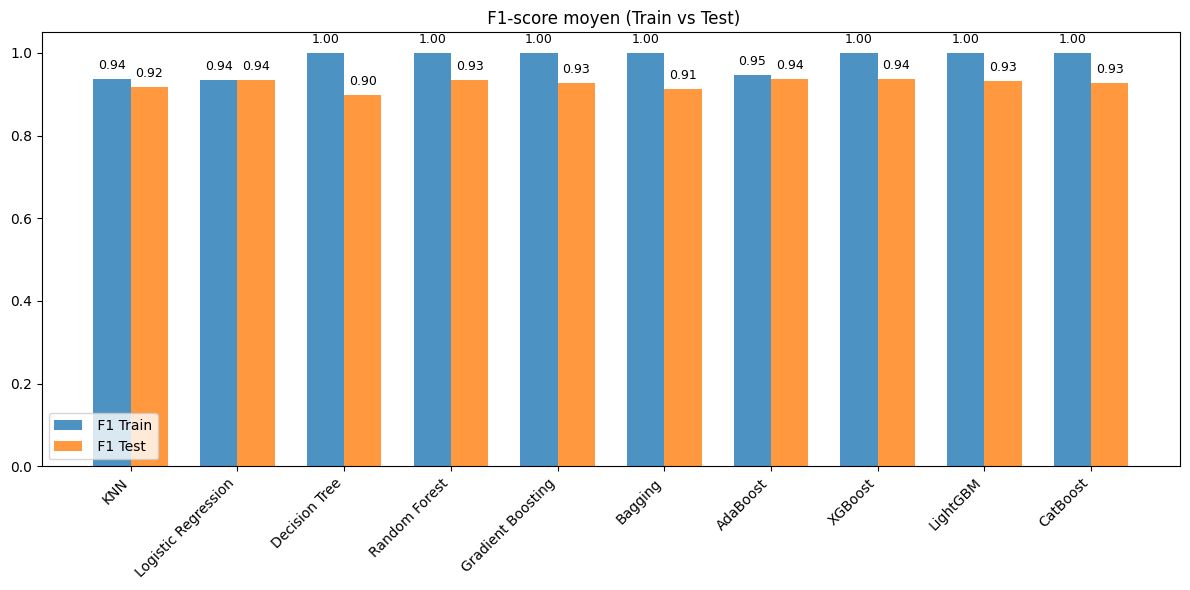

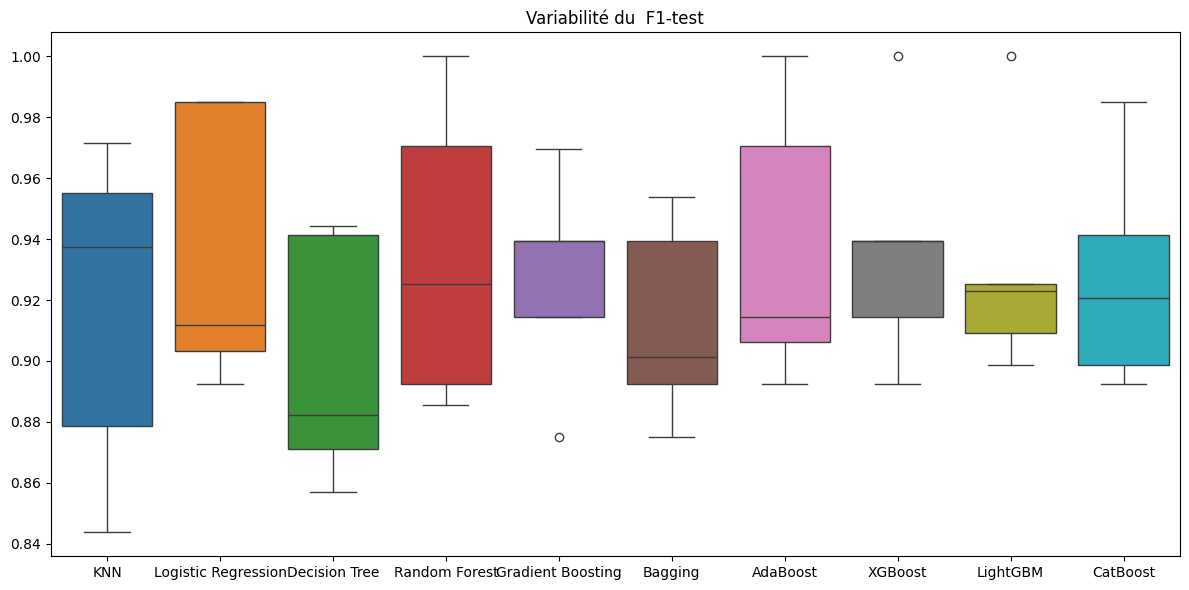

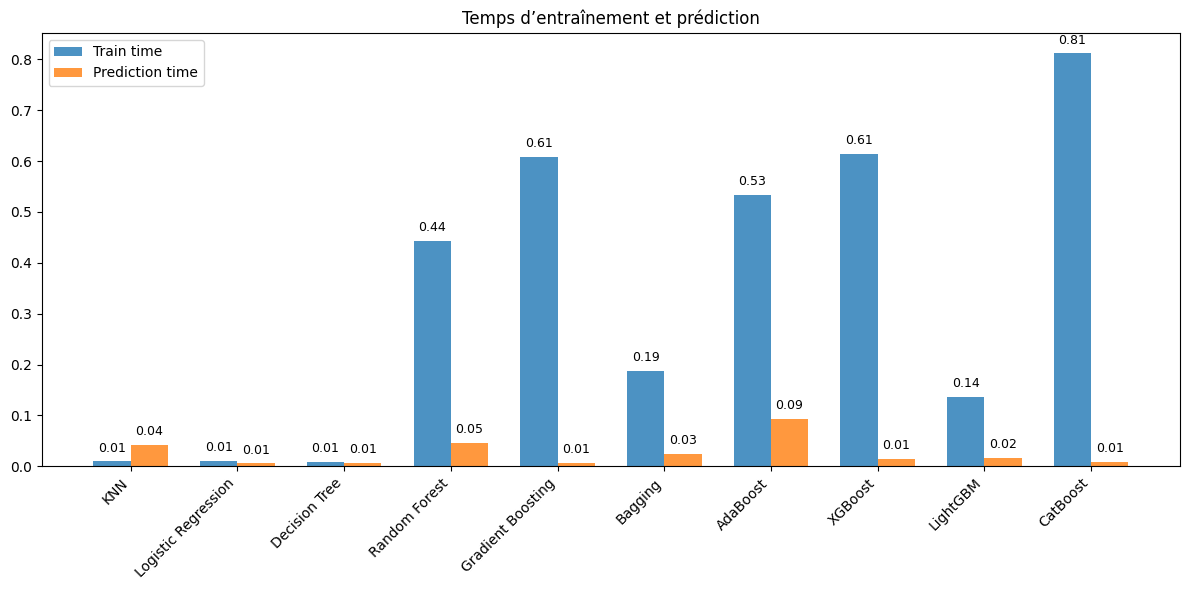

,F1_train_mean,F1_test_mean,F1_test_std,Train_time,Pred_time,Score_global
KNN,0.936573,0.917338,0.048309,0.009599,0.042868,0.912078
Logistic Regression,0.935590,0.935489,0.040953,0.011403,0.005598,0.931338
Decision Tree,1.000000,0.899217,0.036493,0.009399,0.006000,0.895508
Random Forest,1.000000,0.934797,0.044352,0.441991,0.045635,0.929905
Gradient Boosting,1.000000,0.927554,0.031605,0.607740,0.007203,0.924322
Bagging,0.999262,0.912391,0.029563,0.187397,0.025201,0.909183
AdaBoost,0.946590,0.936686,0.041366,0.533775,0.092980,0.931620
XGBoost,0.999262,0.937076,0.036038,0.614447,0.013601,0.933336
LightGBM,1.000000,0.931218,0.035744,0.135881,0.015686,0.927487
CatBoost,1.000000,0.927549,0.033543,0.811339,0.009400,0.924101


In [21]:
X_proc, y = advanced_feature_preprocessing_breast_cancer(
    train,
    n_features=10,
    n_components=5,
    methods=['ANOVA']
)
modelisation_classification_binaire_F1_visualisee(X_proc, y, cv_splits=5)

Avec la sélection ANOVA, les modèles d’ensemble restent les plus performants :
XGBoost, AdaBoost, Random Forest et Gradient Boosting obtiennent les meilleurs scores (F1_test ≈ 0.93–0.94).

La régression logistique est stable mais légèrement derrière (≈ 0.93).

LightGBM et CatBoost restent solides, mais un peu limités par la sélection de variables.

KNN, Bagging et surtout Decision Tree sont les moins compétitifs dans ce contexte.

**Conclusion générale**

PCA est la méthode la plus efficace : elle offre les meilleurs F1_test moyens, avec XGBoost (≈0.961) et Logistic Regression (≈0.960) en tête, tout en gardant une bonne stabilité et des temps d’exécution raisonnables.

RFE arrive en deuxième position : elle améliore surtout les modèles linéaires comme la régression logistique (≈0.942), mais elle pénalise légèrement les modèles complexes qui utilisent des interactions.

ANOVA est la moins performante : bien que correcte, elle donne des F1 plus faibles (≈0.93 max) et des écarts-types plus élevés, notamment pour Random Forest et Gradient Boosting.

En résumé : la PCA est la meilleure méthode de réduction, car c’est celle qui produit les scores les plus élevés et les plus stables, tout en profitant aux modèles les plus performants (XGBoost, Logistic Regression).

## 3. Optimisation des hyperparamètres via RandomizedSearchCV

In [119]:
hyperparam_optimization(X_train, y_train)


--- Optimisation de Random Forest ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


→ Meilleurs paramètres : {'model__n_estimators': 500, 'model__max_features': 0.8, 'model__max_depth': None}
→ Meilleur score F2 : 0.9520

--- Optimisation de Gradient Boosting ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


→ Meilleurs paramètres : {'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.2}
→ Meilleur score F2 : 0.9433

--- Optimisation de XGBoost ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:02:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


→ Meilleurs paramètres : {'model__n_estimators': 500, 'model__max_depth': 5, 'model__learning_rate': 0.1}
→ Meilleur score F2 : 0.9552

--- Optimisation de LightGBM ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Number of positive: 170, number of negative: 285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4545
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


({'Random Forest': Pipeline(steps=[('preprocess',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('num', StandardScaler(),
                                                    ['radius1', 'texture1',
                                                     'perimeter1', 'area1',
                                                     'smoothness1',
                                                     'compactness1', 'concavity1',
                                                     'concave_points1',
                                                     'symmetry1',
                                                     'fractal_dimension1',
                                                     'radius2', 'texture2',
                                                     'perimeter2', 'area2',
                                                     'smoothness2',
                                                     'compactness2', 'conca

## Evaluation sur la partie test du modèle

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, recall_score,precision_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    BaggingClassifier, AdaBoostClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

def train_best_models_no_cv(
    X_train, y_train, X_test, y_test,
    reduction_method=None,
    n_components=5,
    n_features=10
):

    #   1) Ajout du cluster KMeans  
    kmeans = KMeans(n_clusters=2, random_state=42)
    X_train = X_train.copy()
    X_test = X_test.copy()
    X_train["cluster"] = kmeans.fit_predict(X_train)
    X_test["cluster"] = kmeans.predict(X_test)

    #   2) Sélection du preprocess  
    numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
    preprocess = ColumnTransformer(
        [('num', StandardScaler(), numeric_features)],
        remainder='passthrough'
    )

    #   3) Réduction dimensionnelle  
    reducer = None
    if reduction_method == "PCA":
        reducer = PCA(n_components=n_components)
    elif reduction_method == "ANOVA":
        reducer = SelectKBest(score_func=f_classif, k=n_features)
    elif reduction_method == "RFE":
        reducer = RFE(estimator=LogisticRegression(max_iter=2000), n_features_to_select=n_features)

    #   4) Meilleurs hyperparamètres  
    best_params = {
        'Random Forest': {'model__n_estimators': 500, 'model__max_features': 0.8, 'model__max_depth': None},
        'Gradient Boosting': {'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.2},
        'XGBoost': {'model__n_estimators': 500, 'model__max_depth': 5, 'model__learning_rate': 0.1},
        'LightGBM': {'model__num_leaves': 31, 'model__n_estimators': 200, 'model__learning_rate': 0.2},
        'Logistic Regression': {'model__solver': 'lbfgs', 'model__penalty': 'l2', 'model__C': 10}
    }

    models = {
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "XGBoost": XGBClassifier(eval_metric="logloss", use_label_encoder=False),
        "LightGBM": LGBMClassifier(),
        "Logistic Regression": LogisticRegression(max_iter=3000)
    }

    #   5) Structure résultats  
    results = []

    print("\n  Entraînement direct sur train → test  \n")

    for name, model in models.items():

        print(f"--- Modèle : {name} ---")

        pipeline_steps = [("preprocess", preprocess)]
        if reducer is not None:
            pipeline_steps.append(("reducer", reducer))
        pipeline_steps.append(("model", model))

        pipe = Pipeline(pipeline_steps)

        # Chargement des meilleurs hyperparamètres
        pipe.set_params(**best_params[name])

        # Entraînement
        t0 = time.time()
        pipe.fit(X_train, y_train)
        t1 = time.time()

        # Prédiction
        y_pred_train = pipe.predict(X_train)
        y_pred_test = pipe.predict(X_test)
        t2 = time.time()

        # Scores
        F1_train = f1_score(y_train, y_pred_train )
        F1_test = f1_score(y_test, y_pred_test )
        precision_score_test = precision_score(y_test, y_pred_test )
        recall_score_test = recall_score(y_test, y_pred_test )

        print(f" F1-train = {F1_train:.3f} |  F1-test = {F1_test:.3f}")
        print(f"Temps entraînement = {t1 - t0:.4f}s | Temps prédiction = {t2 - t1:.4f}s\n")

        results.append({
            "Model": name,
            "F1_train": F1_train,
            "F1_test": F1_test,
            "precision_score_test": precision_score_test,
            "recall_score_test": recall_score_test,
            "Train_time": t1 - t0,
            "Pred_time": t2 - t1,
            "Pipeline": pipe
        })

    results_df = pd.DataFrame(results)

    #   6) Graphiques  
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results_df, x="Model", y="F1_test")
    plt.title(" F1-test des modèles")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Confusion matrix + ROC pour le meilleur modèle
    best = results_df.loc[results_df["F1_test"].idxmax()]
    best_model = best["Pipeline"]
    y_pred = best_model.predict(X_test)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matrice de confusion – {best['Model']}")
    plt.show()

    # ROC
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:, 1]
    else:
        y_proba = best_model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title(f"ROC – {best['Model']}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.show()

    print("\n  Meilleur modèle sur TEST  ")
    print(best[["Model", "F1_train", "F1_test"]])

    return results_df, best_model


In [46]:
df, train, test, X_train, y_train, X_test, y_test = chargement_donnees_ucirepo()

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

C:\Users\MEHOUN MARTINIEN\AppData\Local\Temp\ipykernel_13916\2571452646.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({"M": 1, "B": 0})



===== Entraînement direct sur train → test =====

--- Modèle : Random Forest ---
 F1-train = 1.000 |  F1-test = 0.963
Temps entraînement = 3.4260s | Temps prédiction = 0.0979s

--- Modèle : Gradient Boosting ---
 F1-train = 1.000 |  F1-test = 0.950
Temps entraînement = 1.4326s | Temps prédiction = 0.0100s

--- Modèle : XGBoost ---


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:48:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 F1-train = 1.000 |  F1-test = 0.950
Temps entraînement = 0.4040s | Temps prédiction = 0.0101s

--- Modèle : LightGBM ---
[LightGBM] [Info] Number of positive: 170, number of negative: 285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4548
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


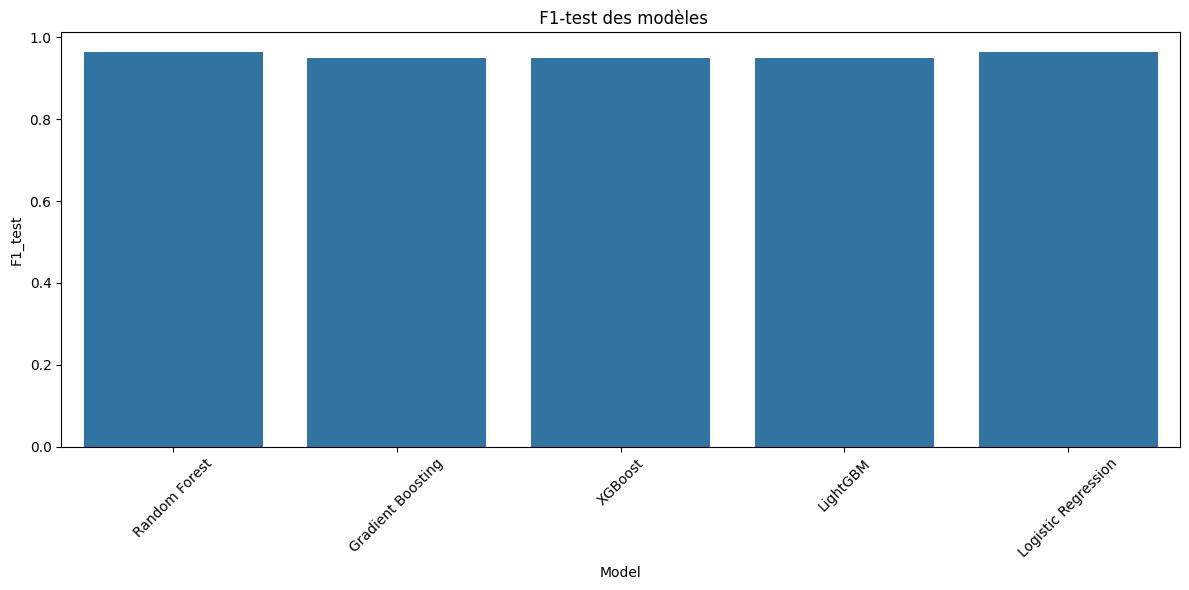

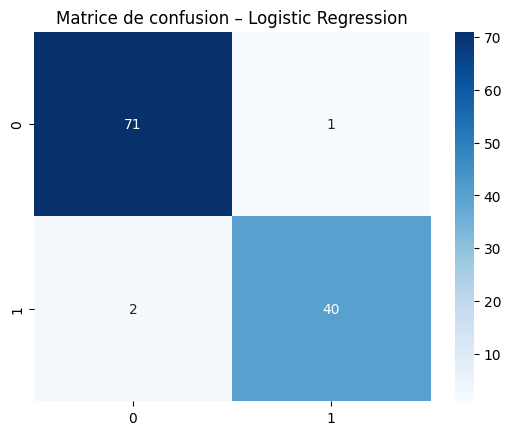

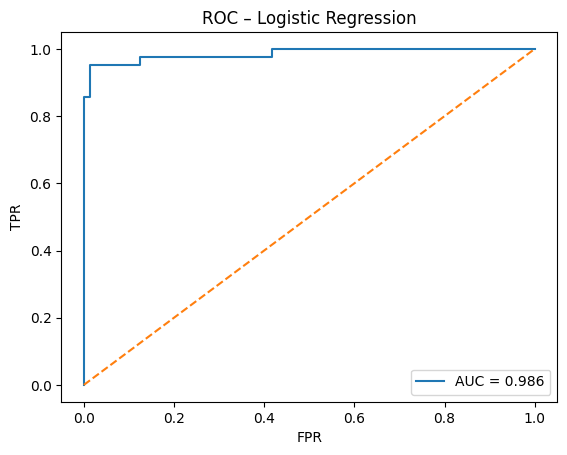


===== Meilleur modèle sur TEST =====
Model       Logistic Regression
F1_train               0.988095
F1_test                0.963855
Name: 4, dtype: object


,Model,F1_train,F1_test,precision_score_test,recall_score_test,Train_time,Pred_time
0,Random Forest,1.000000,0.962963,1.00000,0.928571,3.425958,0.097887
1,Gradient Boosting,1.000000,0.950000,1.00000,0.904762,1.432582,0.010029
2,XGBoost,1.000000,0.950000,1.00000,0.904762,0.404029,0.010053
3,LightGBM,1.000000,0.950000,1.00000,0.904762,0.117107,0.016015
4,Logistic Regression,0.988095,0.963855,0.97561,0.952381,0.019391,0.000665


In [45]:
results_df, best_model=train_best_models_no_cv(
    X_train, y_train, X_test, y_test,
    reduction_method=None
)
results_df=pd.DataFrame(results_df)
results_df.drop(columns=['Pipeline'])

Avec les techniques de réduction de dimension , on a trouvé que le PCA était le meilleur donc on va l'utiliser pour comparer


===== Entraînement direct sur train → test =====

--- Modèle : Random Forest ---
 F1-train = 1.000 |  F1-test = 0.916
Temps entraînement = 1.8290s | Temps prédiction = 0.1050s

--- Modèle : Gradient Boosting ---
 F1-train = 1.000 |  F1-test = 0.914
Temps entraînement = 0.5740s | Temps prédiction = 0.0120s

--- Modèle : XGBoost ---


c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:15:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 F1-train = 1.000 |  F1-test = 0.938
Temps entraînement = 0.3540s | Temps prédiction = 0.0120s

--- Modèle : LightGBM ---
[LightGBM] [Info] Number of positive: 170, number of negative: 285
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 760
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.373626 -> initscore=-0.516691
[LightGBM] [Info] Start training from score -0.516691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\MEHOUN MARTINIEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


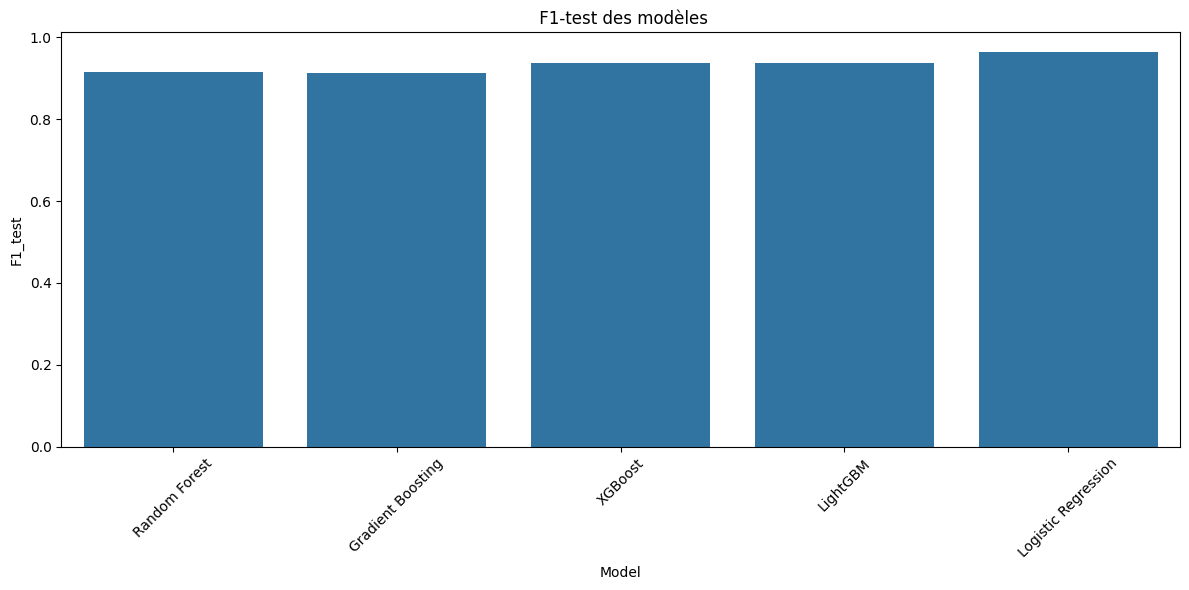

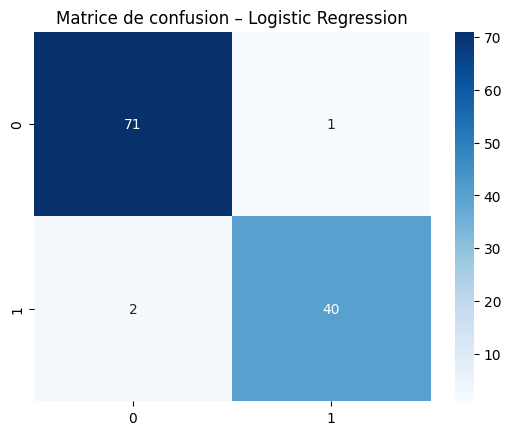

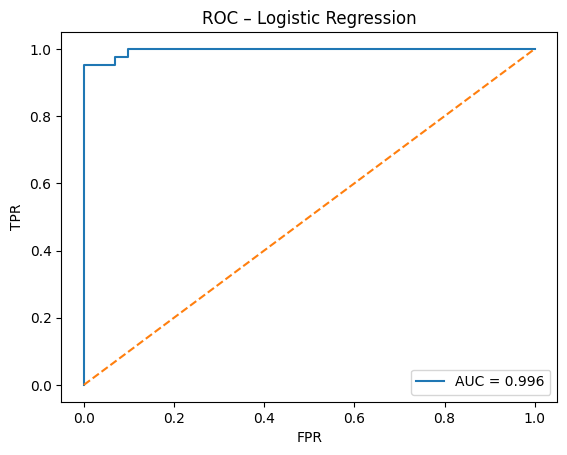


===== Meilleur modèle sur TEST =====
Model       Logistic Regression
F1_train               0.967552
F1_test                0.963855
Name: 4, dtype: object


,Model,F1_train,F1_test,precision_score_test,recall_score_test,Train_time,Pred_time
0,Random Forest,1.000000,0.915663,0.926829,0.904762,1.828992,0.105000
1,Gradient Boosting,1.000000,0.913580,0.948718,0.880952,0.573997,0.012001
2,XGBoost,1.000000,0.938272,0.974359,0.904762,0.353998,0.012000
3,LightGBM,1.000000,0.938272,0.974359,0.904762,0.087001,0.028012
4,Logistic Regression,0.967552,0.963855,0.975610,0.952381,0.019975,0.007001


In [49]:
results_df, best_model=train_best_models_no_cv(
    X_train, y_train, X_test, y_test,
    reduction_method='PCA'
)
results_df=pd.DataFrame(results_df)
results_df.drop(columns=['Pipeline'])

Avec ou sans PCA le resultat est le même

**Interprétation des résultats**

Les performances montrent deux modèles en tête :

Random Forest et Logistic Regression, avec un F1_test ≈ 0.963, les meilleurs du tableau.

Cependant, leurs profils sont différents :

Random Forest atteint une précision parfaite (1.00) mais un rappel légèrement plus faible, avec un temps d’entraînement beaucoup plus élevé.

Logistic Regression obtient un excellent équilibre : précision 0.976, rappel 0.952, et des temps d’entraînement/prédiction extrêmement faibles.

Meilleur choix

Le meilleur modèle global est la **Régression Logistique**, car :

elle offre le meilleur F1_test (≈0.964),

elle maintient un très bon rappel (important pour ne pas rater les tumeurs),

elle est de loin la plus rapide et la plus simple à exploiter.

Conclusion opérationnelle

Pour un usage réel où la stabilité, la rapidité et la capacité à bien détecter les cas positifs sont essentielles, la Régression Logistique est le modèle le plus sûr et le plus performant sur vos données.